# 1. Yahoo Finance Data

In [78]:
# import yahoo finance library
# and get daily stock price data of dow jones index, s&p 500 index, and nasdaq, and each sector index
# from the 1980 to today
# and inser data into database

import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import sqlite3
import os
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# get the dow jones index, s&p 500 index, and nasdaq index
# from 1980 to today
# and insert data into database

def get_data(ticker_code, index_name, peroiod="max"):
    # get the data
    data = yf.Ticker(ticker_code)
    data = data.history(period=peroiod)
    data.insert(0, "code", ticker_code)
    data.insert(0, "index_name", index_name)

    ## change column name into small letters
    data = data.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume", "Dividends": "dividends", "Stock Splits": "stock_splits"})
    data.index.name = "date"

    ## change data format
    data.index = pd.to_datetime(data.index, format='%d-%m-%Y')
    data.index = data.index.strftime('%Y-%m-%d')
    data["open"] = data["open"].astype(float)
    data["high"] = data["high"].astype(float)
    data["low"] = data["low"].astype(float)
    data["close"] = data["close"].astype(float)
    data["volume"] = data["volume"].astype(int)
    data["dividends"] = data["dividends"].astype(float)
    data["stock_splits"] = data["stock_splits"].astype(float)

    ## mange missing data
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.fillna(0)
    data = data.round(2)

    return data


# us stock indexes code: dow jones, s&p 500, nasdaq, russell 2000
# us stock sector indexes code: information technology, health care, consumer discretionary, consumer staples, energy, financials, industrials, materials, real estate, utilities
# us stock sector indexes code: XLK, XLV, XLY, XLP, XLE, XLF, XLI, XLB, XLRE, XLU

def get_index_data(codes=["^DJI", "^GSPC", "^IXIC", "^RUT", "XLK", "XLV", "XLY", "XLP", "XLE", "XLF", "XLI", "XLB", "XLRE", "XLU"],
                   indexes=["dow_jones", "s&p_500", "nasdaq", "russell_2000", "information_technology", "health_care", "consumer_discretionary", "consumer_staples", "energy", "financials", "industrials", "materials", "real_estate", "utilities"]):
    
    index_data_df = pd.DataFrame()

    for code, index in zip(codes, indexes):

        print("start = {}, {}".format(code, index))

        index_data = get_data(code, index)
        index_data_df = pd.concat([index_data_df, index_data])

        print("end = {}, {}".format(code, index))
        

    print(index_data_df.head())
    print(index_data_df.tail())
    print(index_data_df.shape)

    return index_data_df


In [79]:
codes = ["^DJI", "^GSPC", "^IXIC", "^RUT", "XLK", "XLV", "XLY", "XLP", "XLE", "XLF", "XLI", "XLB", "XLRE", "XLU"]
idexes = ["dow_jones", "s&p_500", "nasdaq", "russell_2000", "information_technology", "health_care", "consumer_discretionary", "consumer_staples", "energy", "financials", "industrials", "materials", "real_estate", "utilities"]

# for code, index in zip(codes, idexes):
#     print("start = {}, {}".format(code, index))

index_data_df = get_index_data(codes, idexes)

start = ^DJI, dow_jones
end = ^DJI, dow_jones
start = ^GSPC, s&p_500
end = ^GSPC, s&p_500
start = ^IXIC, nasdaq
end = ^IXIC, nasdaq
start = ^RUT, russell_2000
end = ^RUT, russell_2000
start = XLK, information_technology
end = XLK, information_technology
start = XLV, health_care
end = XLV, health_care
start = XLY, consumer_discretionary
end = XLY, consumer_discretionary
start = XLP, consumer_staples
end = XLP, consumer_staples
start = XLE, energy
end = XLE, energy
start = XLF, financials
end = XLF, financials
start = XLI, industrials
end = XLI, industrials
start = XLB, materials
end = XLB, materials
start = XLRE, real_estate
end = XLRE, real_estate
start = XLU, utilities
end = XLU, utilities
           index_name  code    open     high      low   close    volume  \
date                                                                      
1992-01-02  dow_jones  ^DJI  3152.1  3172.63  3139.31  3172.4  23550000   
1992-01-03  dow_jones  ^DJI  3172.4  3210.64  3165.92  3201.5  23620000   


# 2. Preprocessing

In [80]:
# Scale the data using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

def scale_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

In [81]:
# index_data_df_test = index_data_df.copy()

# index_data_df_test['close'] = scale_data(index_data_df_test[['close']])

# index_data_df_test['close']

# index_data_df_test = scale_data(index_data_df.columns[["close"]].fillna(0))
# index_data_df_test.info()

# 3. Basic Analysis

In [82]:
index_data_df['code'].unique().tolist()

['^DJI',
 '^GSPC',
 '^IXIC',
 '^RUT',
 'XLK',
 'XLV',
 'XLY',
 'XLP',
 'XLE',
 'XLF',
 'XLI',
 'XLB',
 'XLRE',
 'XLU']

In [94]:
# daily returns

def get_returns(df, interval=1, column_name='daily_rets'):
    
    # get the unique index names
    index_names = df['index_name'].unique().tolist()
    # print(indexes)

    # get daily returns from close price in the dataframe and insert into the dataframe new column named 'daily_rets'

    for index_name in index_names:
        df.loc[df["index_name"] == index_name, column_name] = df.loc[df["index_name"] == index_name]["close"].pct_change(interval)
        df[column_name] = df[column_name].replace([np.inf, -np.inf], np.nan)
        df[column_name] = df[column_name].fillna(0)

    # plot the returns
    for index_name in index_names:

        # plot the returns of each index
        df.loc[df["index_name"] == index_name][column_name].plot()
        plt.xlabel("date")
        plt.ylabel(column_name)
        plt.xticks(rotation=45)
        plt.title(index_name)
        plt.show()

    return df

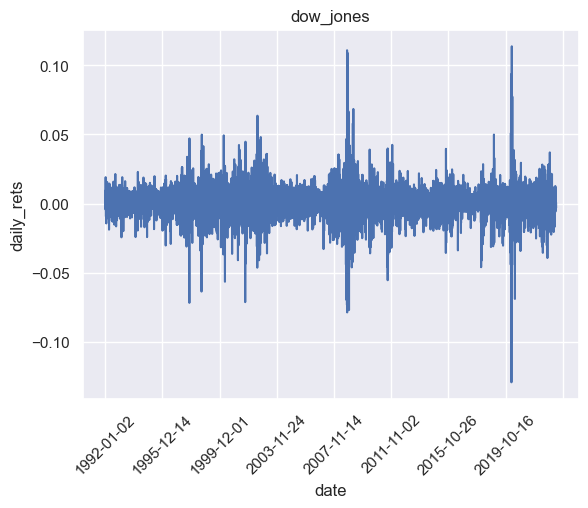

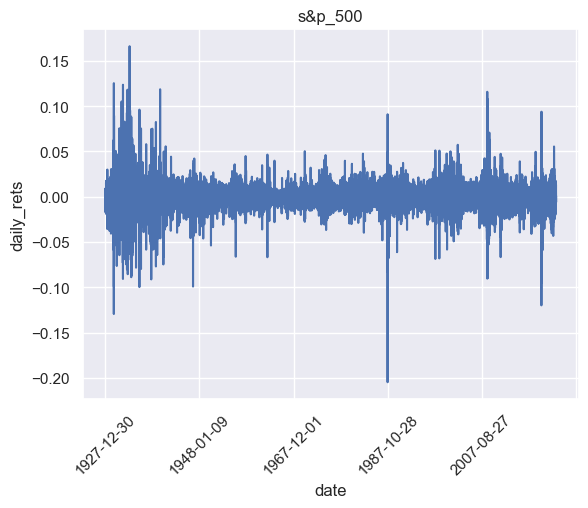

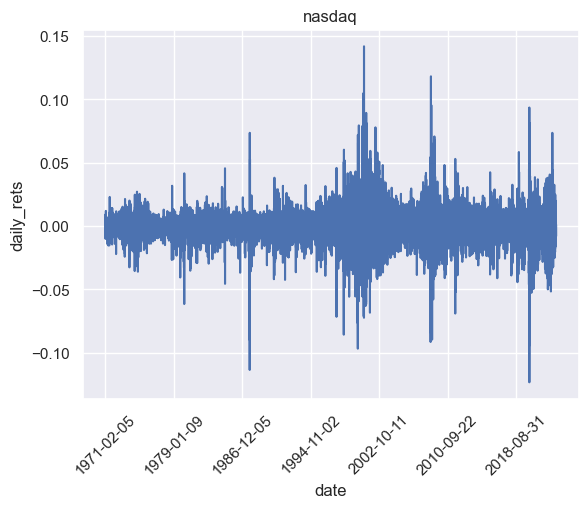

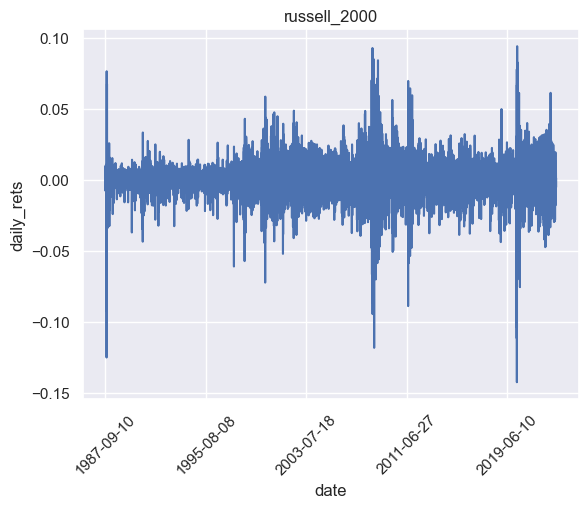

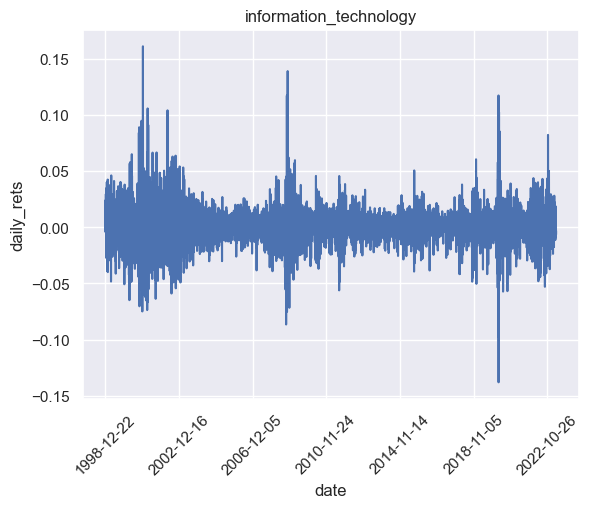

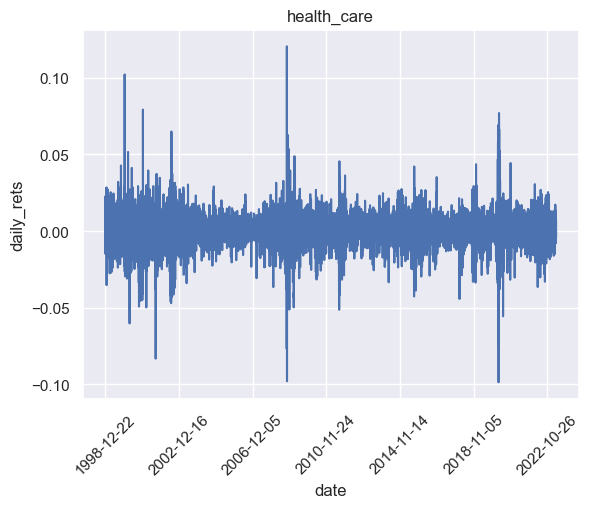

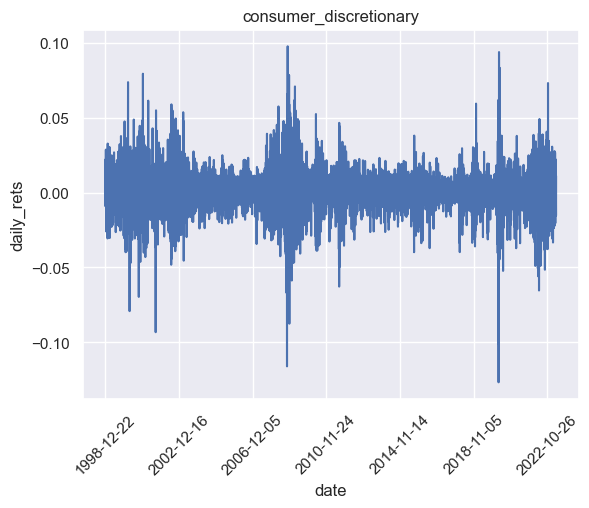

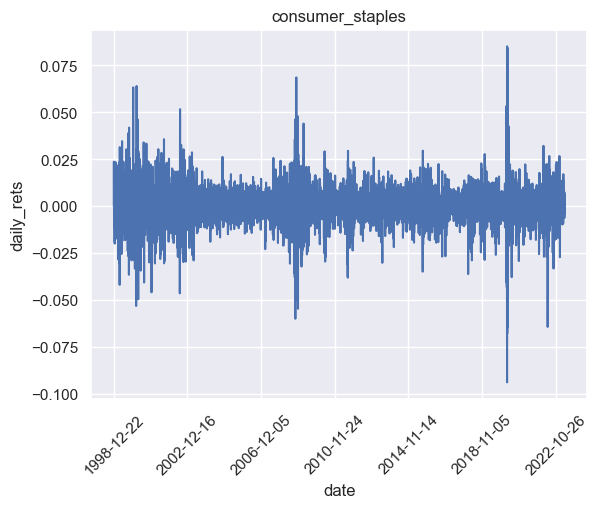

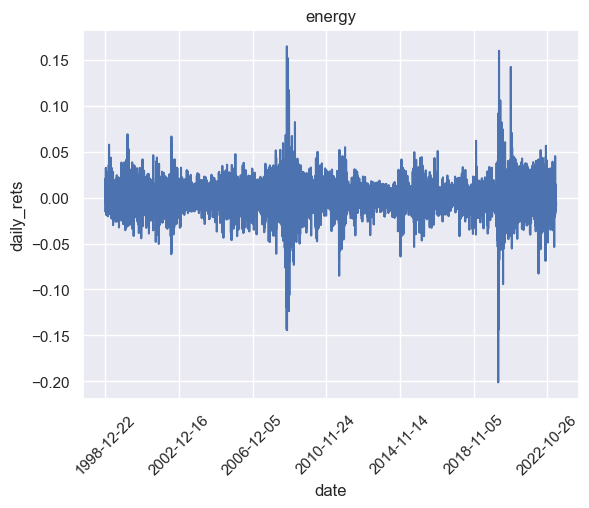

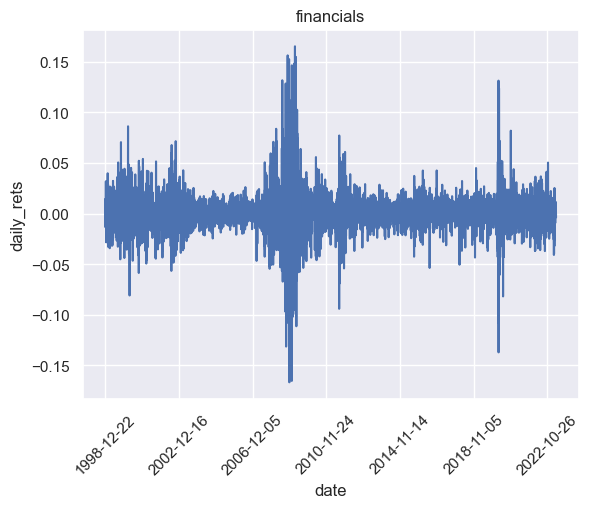

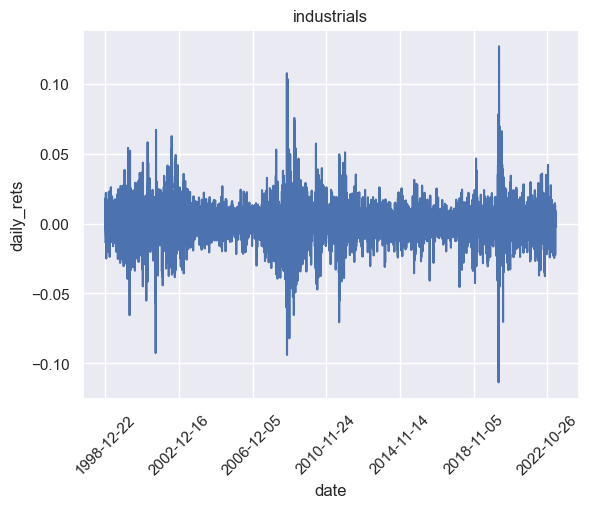

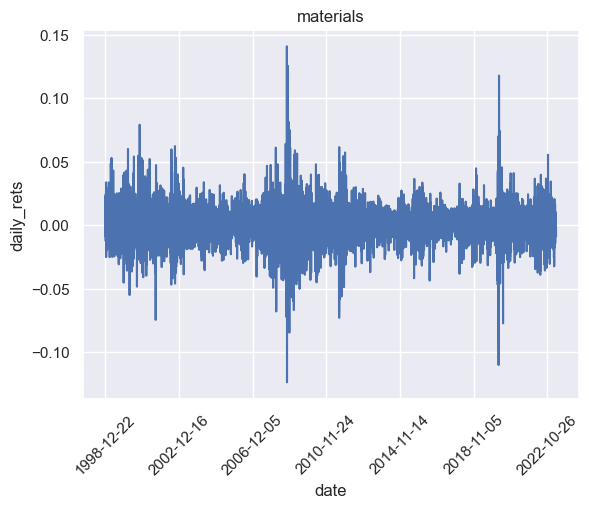

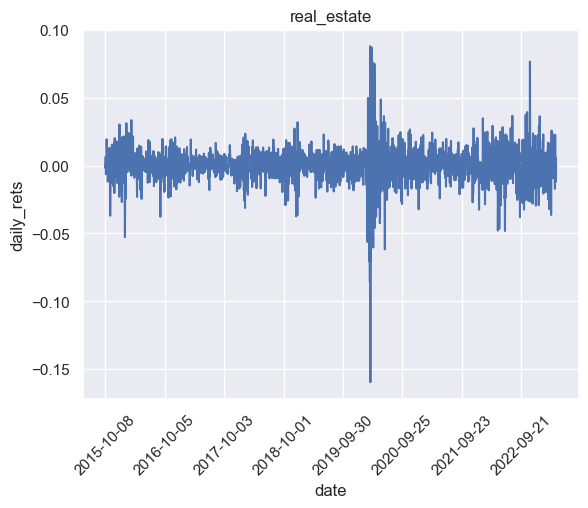

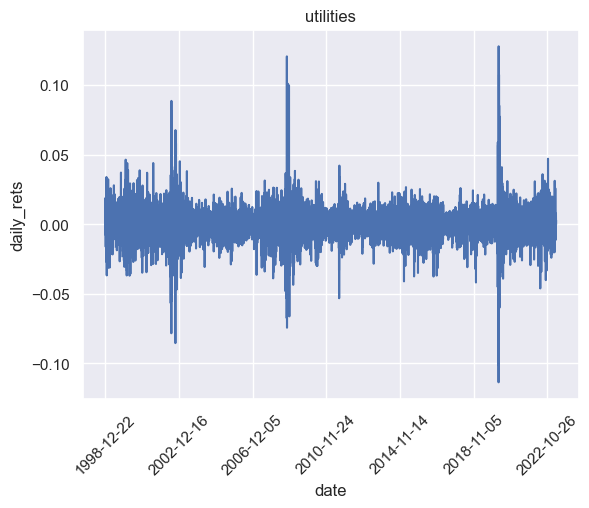

index_name  code     open     high      low    close    volume  \
date                                                                        
1992-01-02  dow_jones  ^DJI  3152.10  3172.63  3139.31  3172.40  23550000   
1992-01-03  dow_jones  ^DJI  3172.40  3210.64  3165.92  3201.50  23620000   
1992-01-06  dow_jones  ^DJI  3201.50  3213.33  3191.86  3200.10  27280000   
1992-01-07  dow_jones  ^DJI  3200.10  3210.20  3184.48  3204.80  25510000   
1992-01-08  dow_jones  ^DJI  3204.80  3229.20  3185.82  3203.90  29040000   
...               ...   ...      ...      ...      ...      ...       ...   
2023-04-17  utilities   XLU    69.01    69.39    68.58    69.27   7806900   
2023-04-18  utilities   XLU    69.30    69.44    68.65    68.91   7783100   
2023-04-19  utilities   XLU    69.08    69.65    68.98    69.44  10317300   
2023-04-20  utilities   XLU    69.50    69.69    69.01    69.42   7368700   
2023-04-21  utilities   XLU    69.87    70.11    69.21    69.62   7037800   

            dividends  stock_splits  Capital Gains  daily_rets  \
date                                                             
1992-01-02        0.0           0.0            NaN    0.000000   
1992-01-03        0.0           0.0            NaN    0.009173   
1992-01-06        0.0           0.0            NaN   -0.000437   
1992-01-07        0.0           0.0            NaN    0.001469   
1992-01-08        0.0           0.0            NaN   -0.000281   
...               ...           ...            ...         ...   
2023-04-17        0.0           0.0            0.0    0.005516   
2023-04-18        0.0           0.0            0.0   -0.005197   
2023-04-19        0.0           0.0            0.0    0.007691   
2023-04-20        0.0           0.0            0.0   -0.000288   
2023-04-21        0.0           0.0            0.0    0.002881   

            monthly_rolling_vol  monthly_rets  yearly_rolling_vol  \
date                                                                
1992-01-02             0.000000      0.000000            0.000000   
1992-01-03             0.000000      0.000000            0.000000   
1992-01-06             0.000000      0.000000            0.000000   
1992-01-07             0.000000      0.000000            0.000000   
1992-01-08             0.000000      0.000000            0.000000   
...                         ...           ...                 ...   
2023-04-17             0.058175      0.053216            1.195794   
2023-04-18             0.057432      0.042827            1.191799   
2023-04-19             0.057417      0.068308            1.191388   
2023-04-20             0.052694      0.059847            1.190938   
2023-04-21             0.047176      0.071571            1.189355   

            yearly_ewm_vol  daily_ewm_vol  
date                                       
1992-01-02        0.000000       0.000000  
1992-01-03        0.000000       0.035526  
1992-01-06        0.000000       0.029780  
1992-01-07        0.000000       0.024241  
1992-01-08        0.000000       0.021839  
...                    ...            ...  
2023-04-17        1.118947       0.063121  
2023-04-18        1.116191       0.061776  
2023-04-19        1.115954       0.060396  
2023-04-20        1.114694       0.058477  
2023-04-21        1.114747       0.056588  

[110963 rows x 16 columns]

In [95]:
index_data_df_rets = get_returns(index_data_df)
index_data_df_rets

In [97]:
# get montly volatility of daily returns of each index

def get_volatility(df, interval=21, type='rolling', column_name='monthly_rolling_vol', rets_column='daily_rets'):
        
    # get the unique index names
    indexes_names = df['index_name'].unique().tolist()
    # print(indexes)
    
    # get monthly volatility from daily returns in the dataframe and insert into the dataframe new column named 'monthly_vol'
    
    for index_name in indexes_names:
        if type == 'rolling':
            df.loc[df["index_name"] == index_name, column_name] = df.loc[df["index_name"] == index_name][rets_column].rolling(interval).std() * np.sqrt(interval)
        elif type == 'ewm':
            df.loc[df["index_name"] == index_name, column_name] = df.loc[df["index_name"] == index_name][rets_column].ewm(span=interval).std() * np.sqrt(interval)
        df[column_name] = df[column_name].replace([np.inf, -np.inf], np.nan)
        df[column_name] = df[column_name].fillna(0)
    
    # plot the volatility
    for index_name in indexes_names:
    
        # plot the volatility of each index
        df.loc[df["index_name"] == index_name][column_name].plot()
        plt.xlabel("date")
        plt.ylabel(column_name)
        plt.title(index_name)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    return df

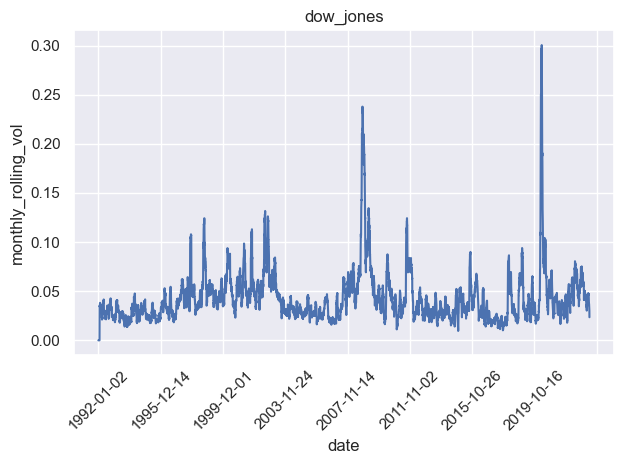

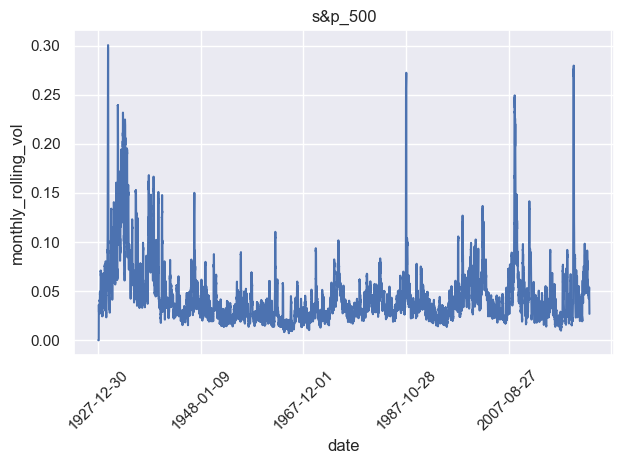

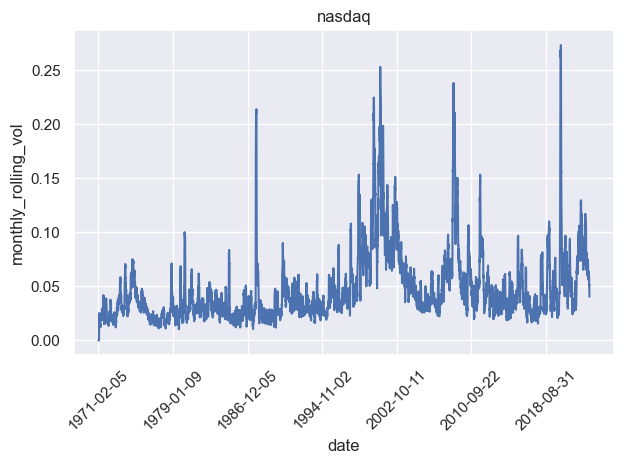

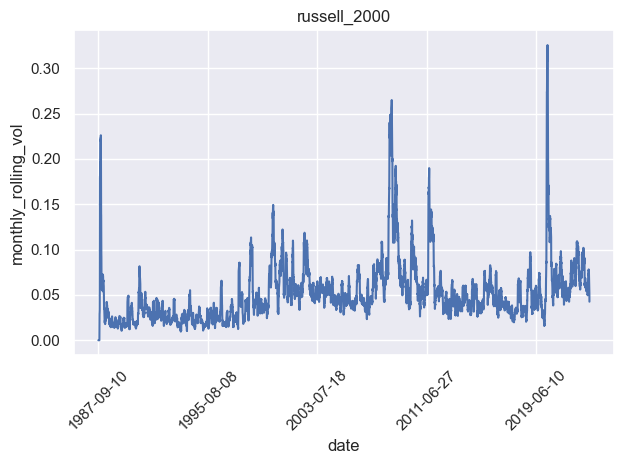

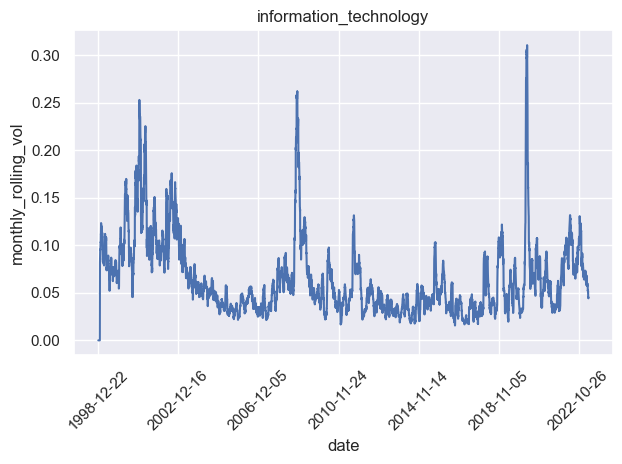

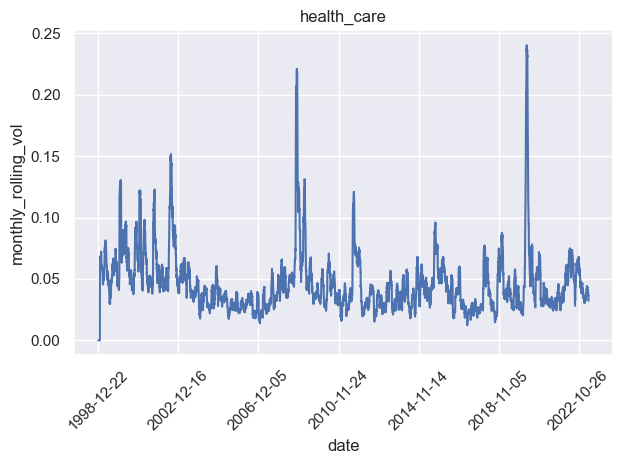

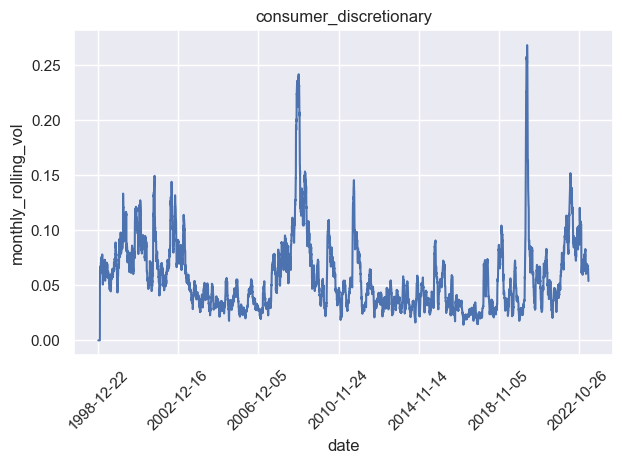

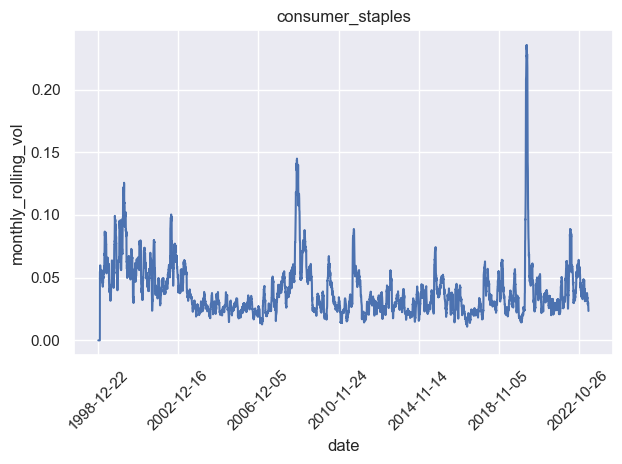

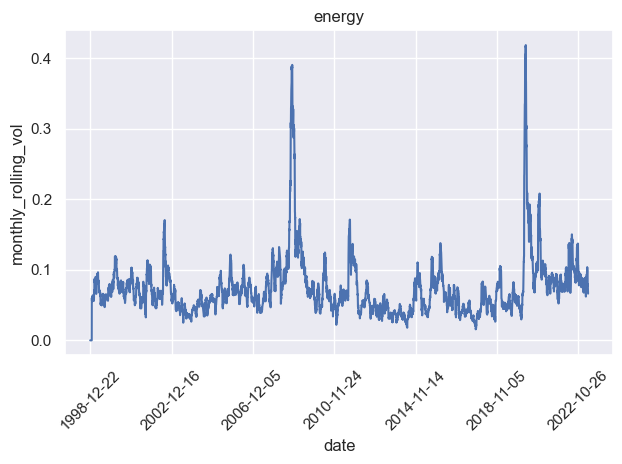

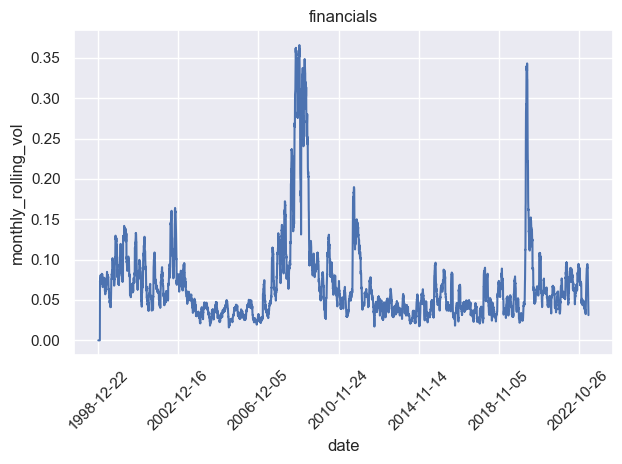

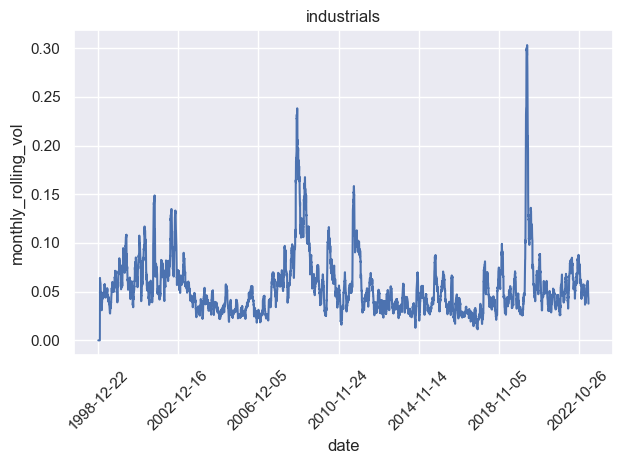

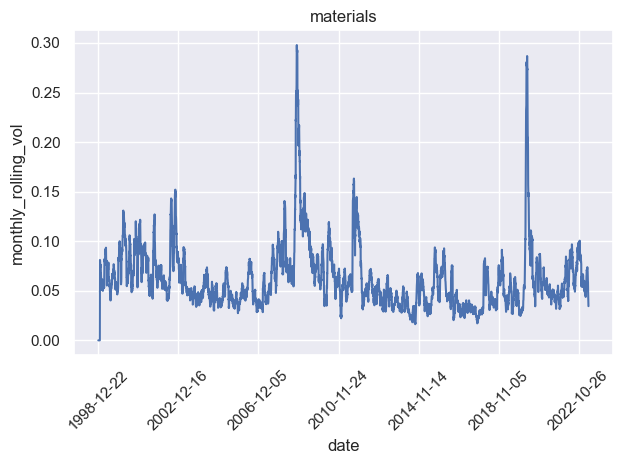

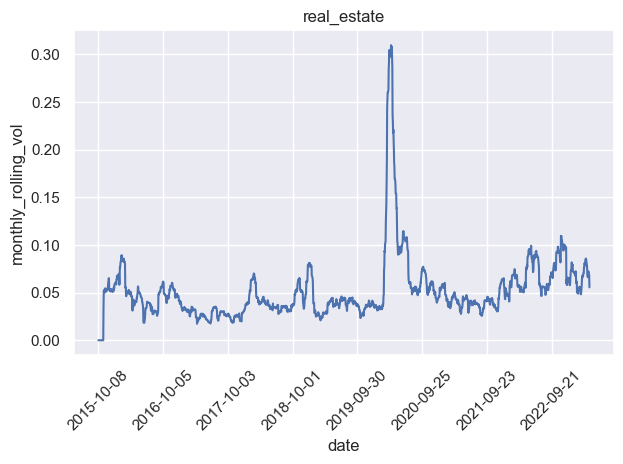

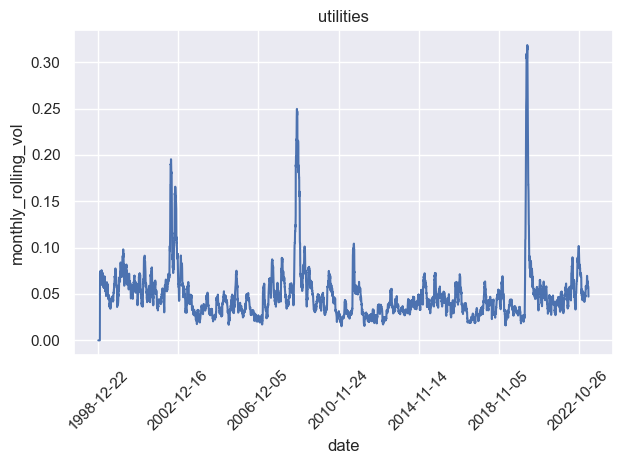

index_name  code     open     high      low    close    volume  \
date                                                                        
1992-01-02  dow_jones  ^DJI  3152.10  3172.63  3139.31  3172.40  23550000   
1992-01-03  dow_jones  ^DJI  3172.40  3210.64  3165.92  3201.50  23620000   
1992-01-06  dow_jones  ^DJI  3201.50  3213.33  3191.86  3200.10  27280000   
1992-01-07  dow_jones  ^DJI  3200.10  3210.20  3184.48  3204.80  25510000   
1992-01-08  dow_jones  ^DJI  3204.80  3229.20  3185.82  3203.90  29040000   
...               ...   ...      ...      ...      ...      ...       ...   
2023-04-17  utilities   XLU    69.01    69.39    68.58    69.27   7806900   
2023-04-18  utilities   XLU    69.30    69.44    68.65    68.91   7783100   
2023-04-19  utilities   XLU    69.08    69.65    68.98    69.44  10317300   
2023-04-20  utilities   XLU    69.50    69.69    69.01    69.42   7368700   
2023-04-21  utilities   XLU    69.87    70.11    69.21    69.62   7037800   

            dividends  stock_splits  Capital Gains  daily_rets  \
date                                                             
1992-01-02        0.0           0.0            NaN    0.000000   
1992-01-03        0.0           0.0            NaN    0.009173   
1992-01-06        0.0           0.0            NaN   -0.000437   
1992-01-07        0.0           0.0            NaN    0.001469   
1992-01-08        0.0           0.0            NaN   -0.000281   
...               ...           ...            ...         ...   
2023-04-17        0.0           0.0            0.0    0.005516   
2023-04-18        0.0           0.0            0.0   -0.005197   
2023-04-19        0.0           0.0            0.0    0.007691   
2023-04-20        0.0           0.0            0.0   -0.000288   
2023-04-21        0.0           0.0            0.0    0.002881   

            monthly_rolling_vol  monthly_rets  yearly_rolling_vol  \
date                                                                
1992-01-02             0.000000      0.000000            0.000000   
1992-01-03             0.000000      0.000000            0.000000   
1992-01-06             0.000000      0.000000            0.000000   
1992-01-07             0.000000      0.000000            0.000000   
1992-01-08             0.000000      0.000000            0.000000   
...                         ...           ...                 ...   
2023-04-17             0.058175      0.053216            1.195794   
2023-04-18             0.057432      0.042827            1.191799   
2023-04-19             0.057417      0.068308            1.191388   
2023-04-20             0.052694      0.059847            1.190938   
2023-04-21             0.047176      0.071571            1.189355   

            yearly_ewm_vol  daily_ewm_vol  
date                                       
1992-01-02        0.000000       0.000000  
1992-01-03        0.000000       0.035526  
1992-01-06        0.000000       0.029780  
1992-01-07        0.000000       0.024241  
1992-01-08        0.000000       0.021839  
...                    ...            ...  
2023-04-17        1.118947       0.063121  
2023-04-18        1.116191       0.061776  
2023-04-19        1.115954       0.060396  
2023-04-20        1.114694       0.058477  
2023-04-21        1.114747       0.056588  

[110963 rows x 16 columns]

In [98]:
index_data_df_rets = get_volatility(index_data_df_rets)
index_data_df_rets

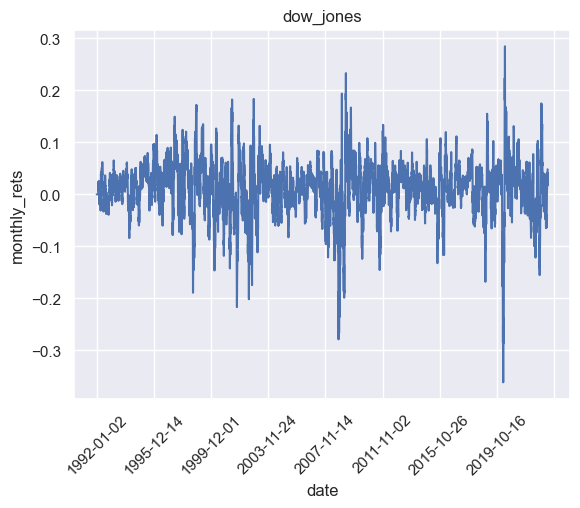

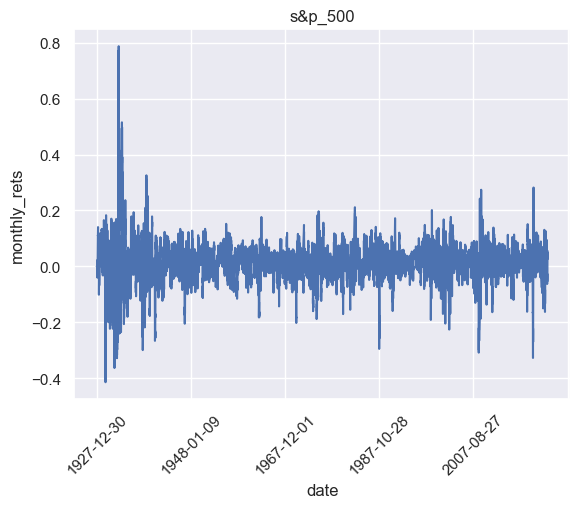

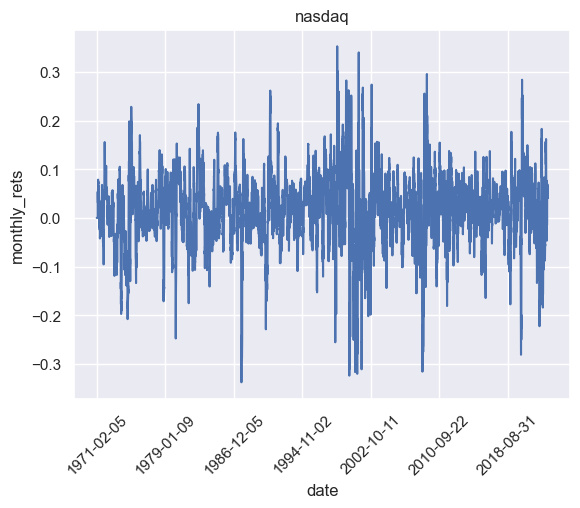

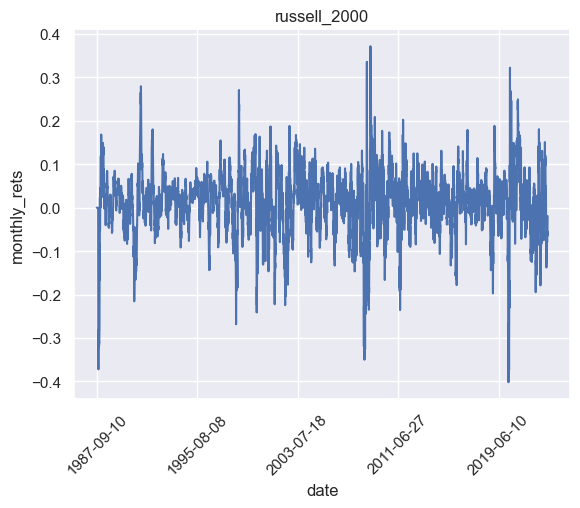

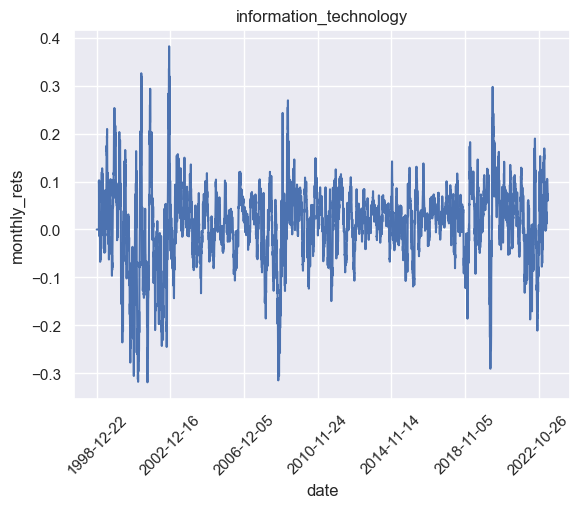

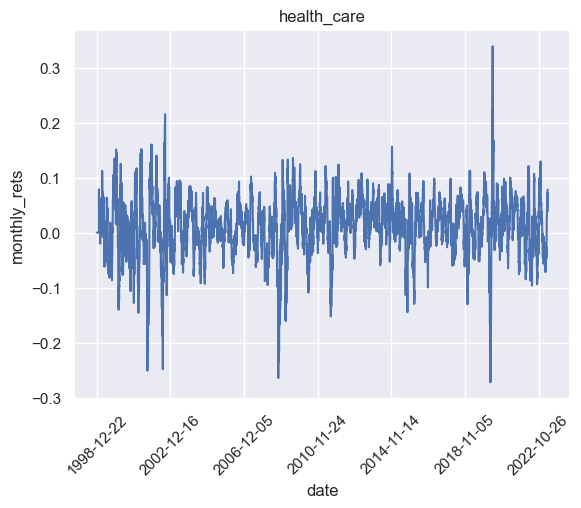

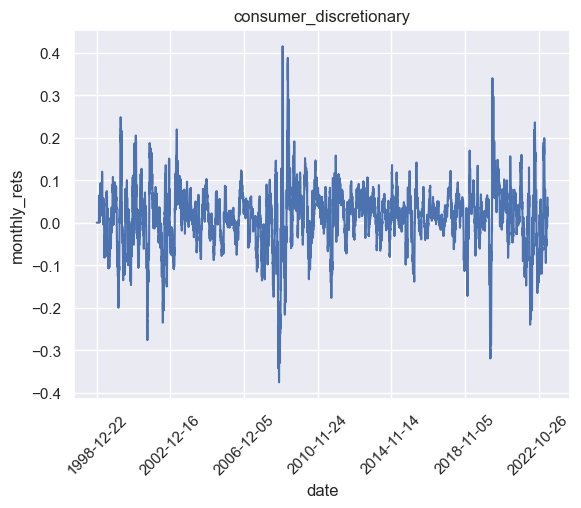

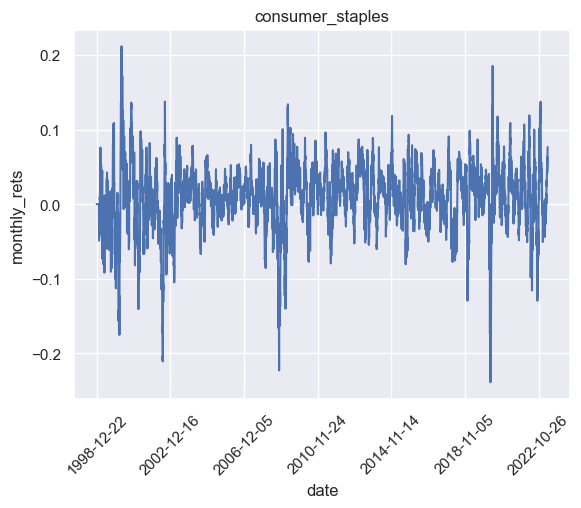

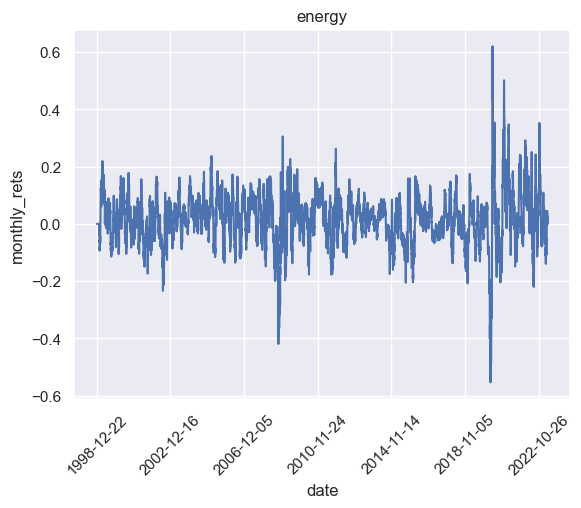

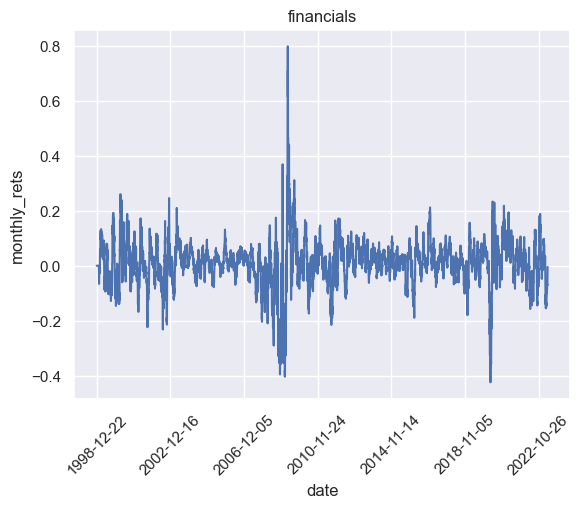

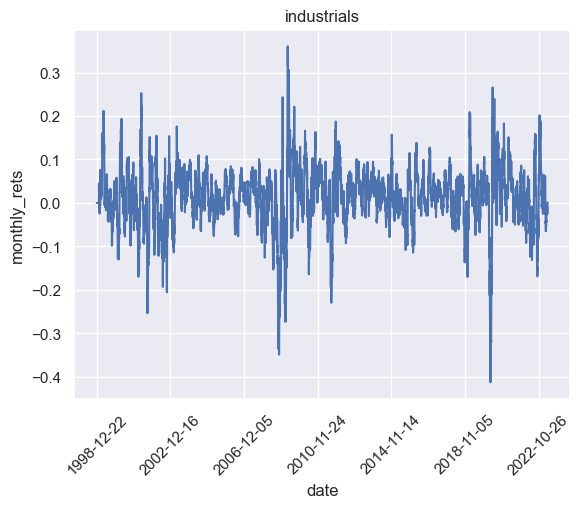

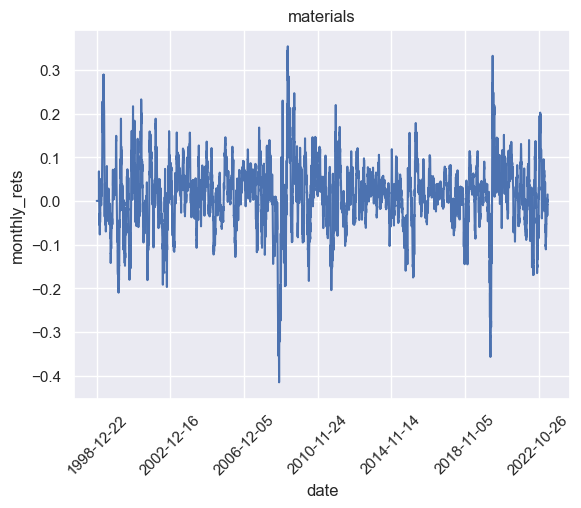

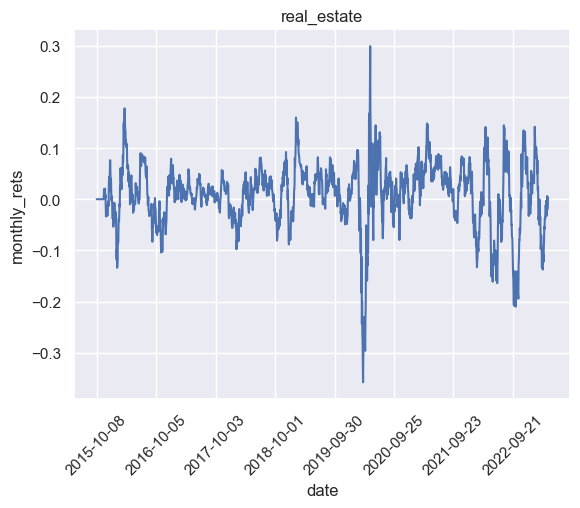

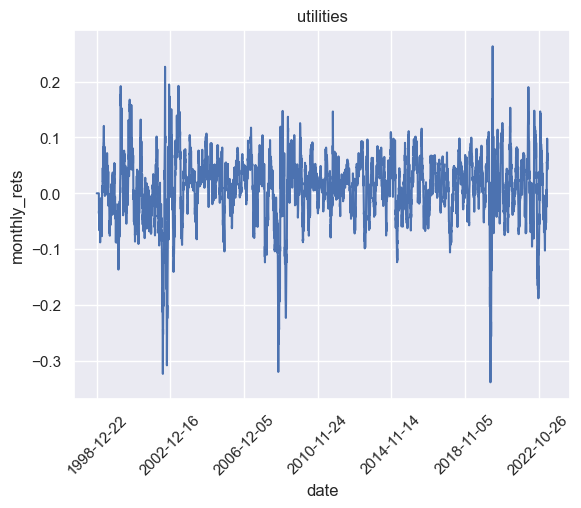

In [99]:
index_data_df_rets = get_returns(index_data_df_rets, interval=30, column_name='monthly_rets')

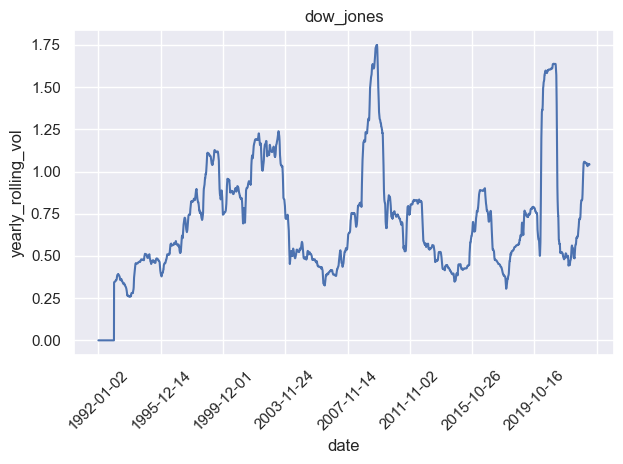

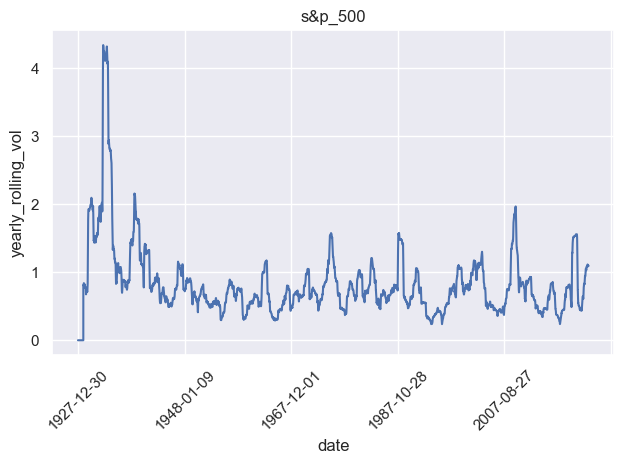

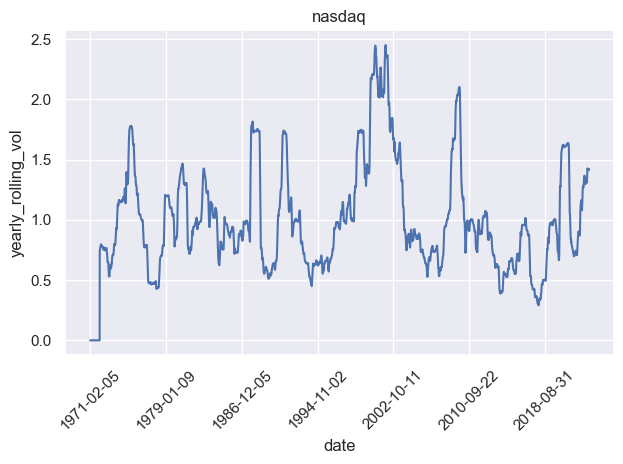

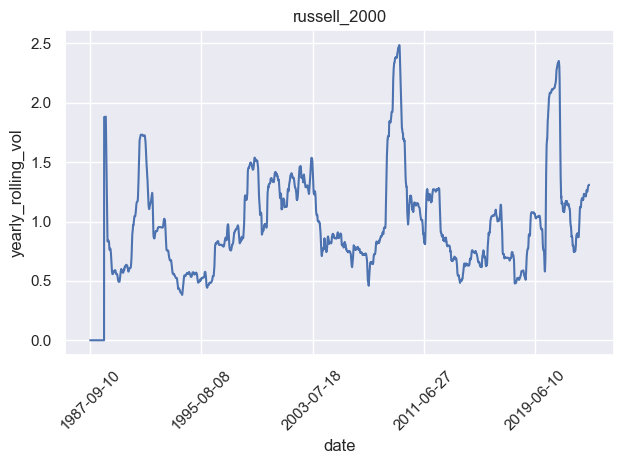

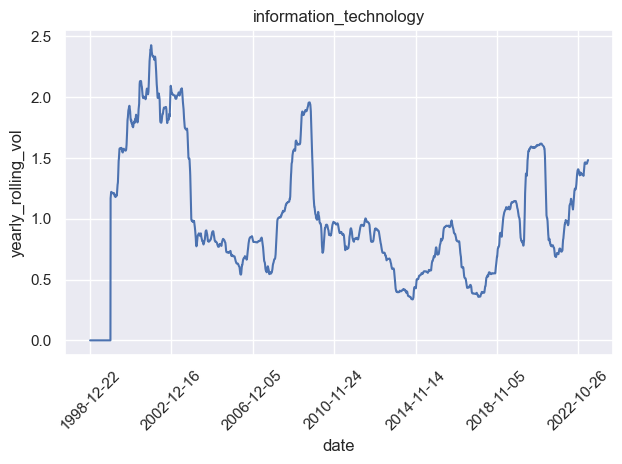

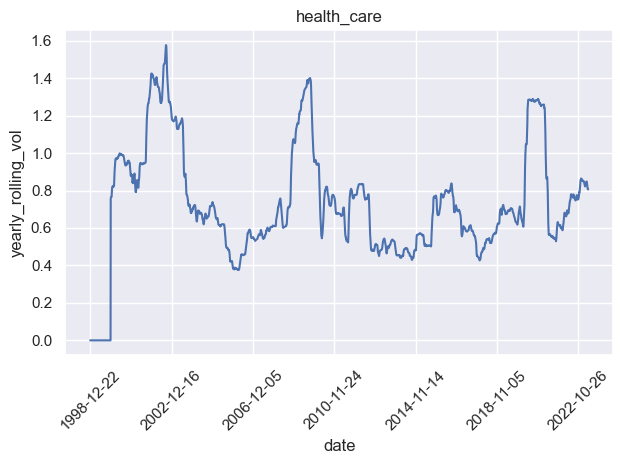

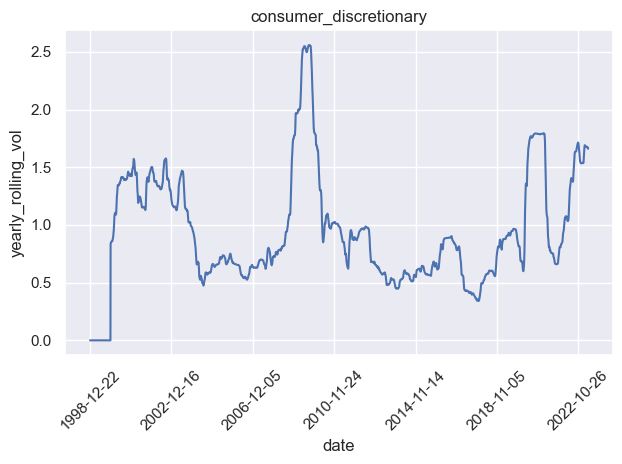

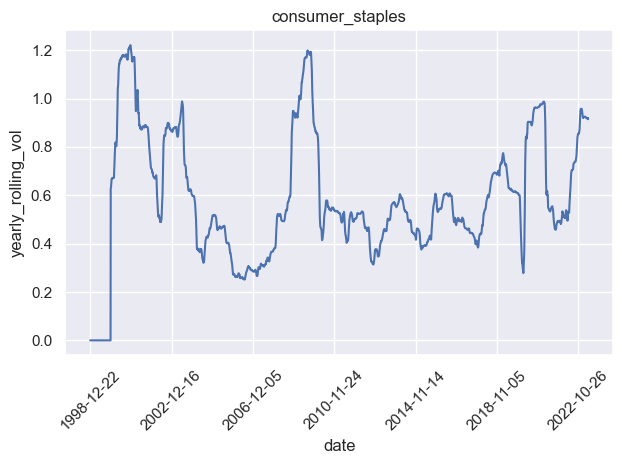

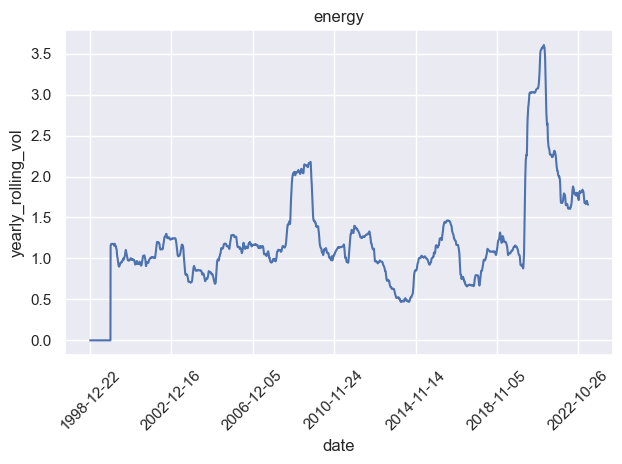

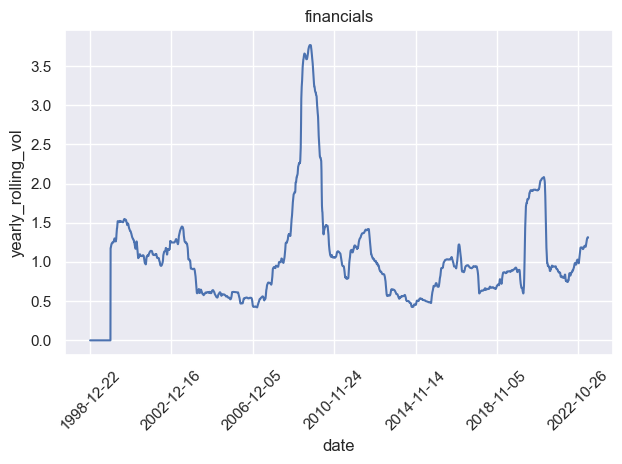

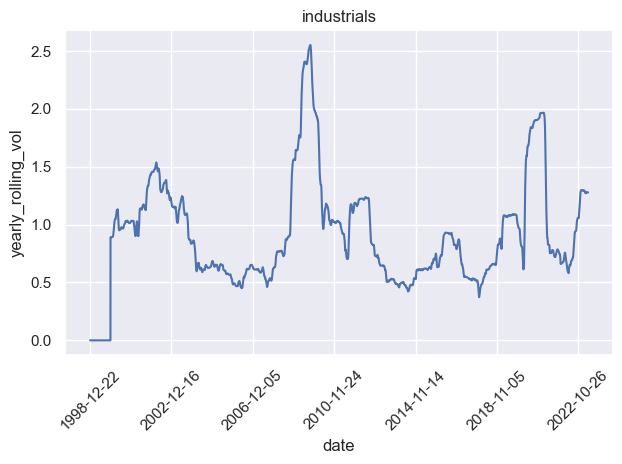

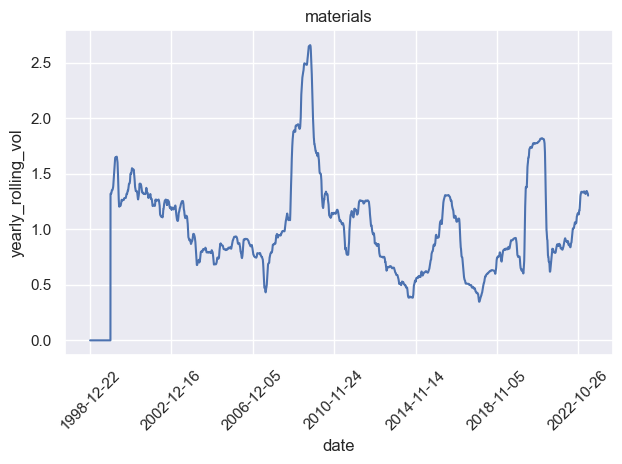

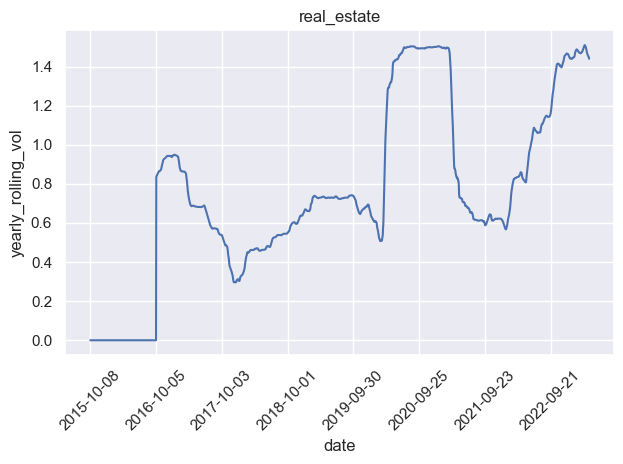

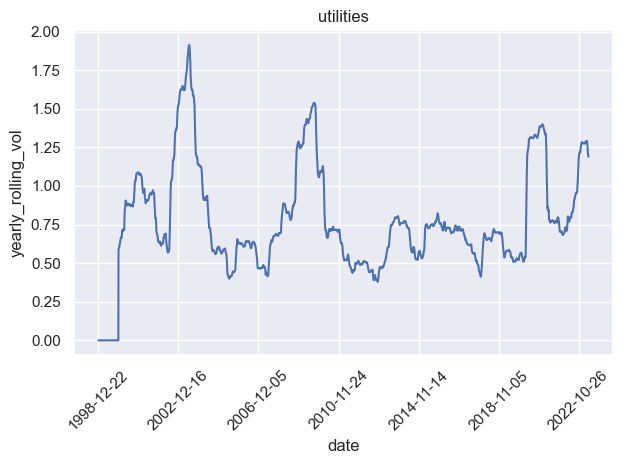

In [100]:
index_data_df_rets = get_volatility(index_data_df_rets, interval=252, type='rolling', column_name='yearly_rolling_vol', rets_column='monthly_rets')

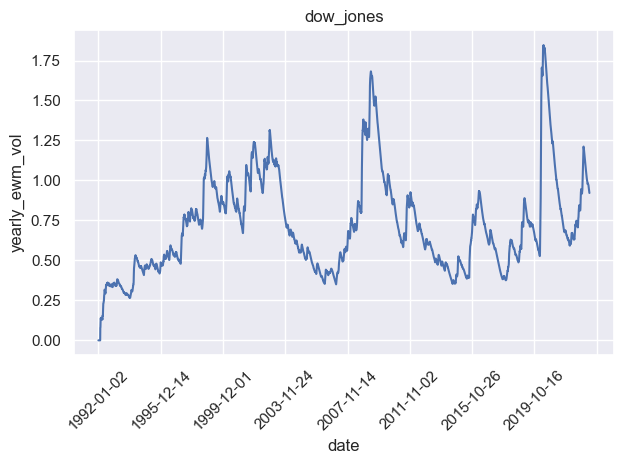

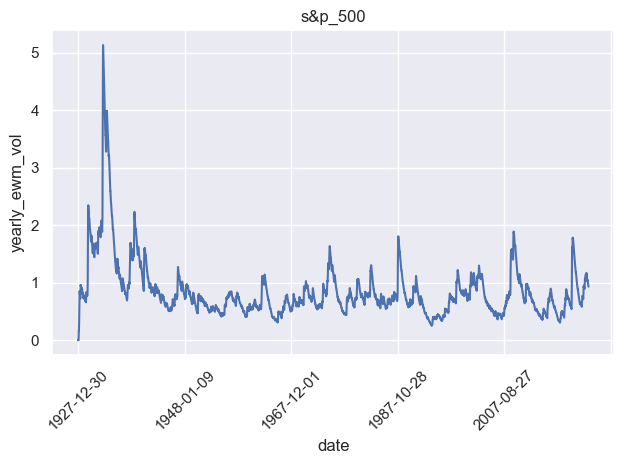

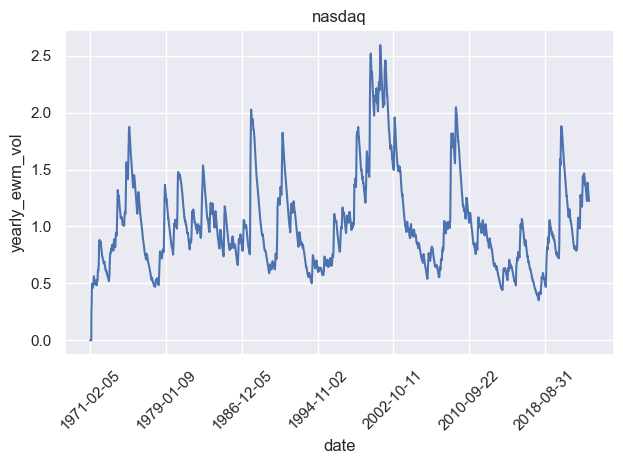

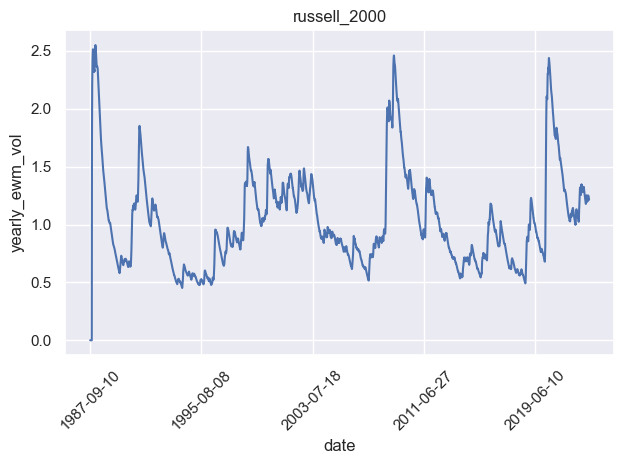

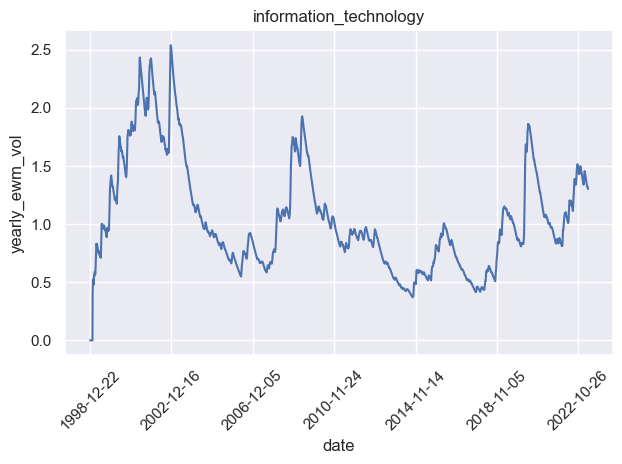

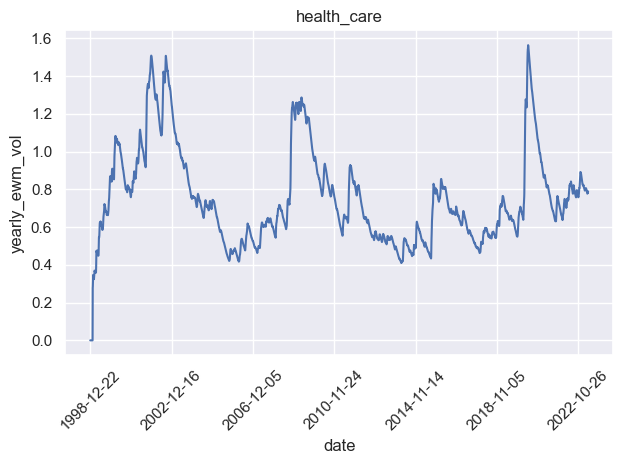

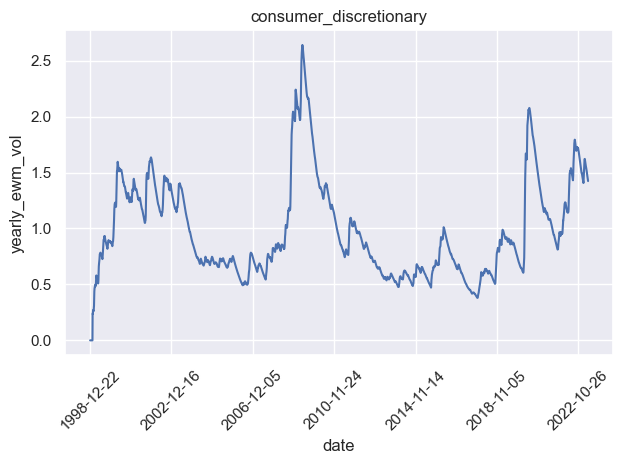

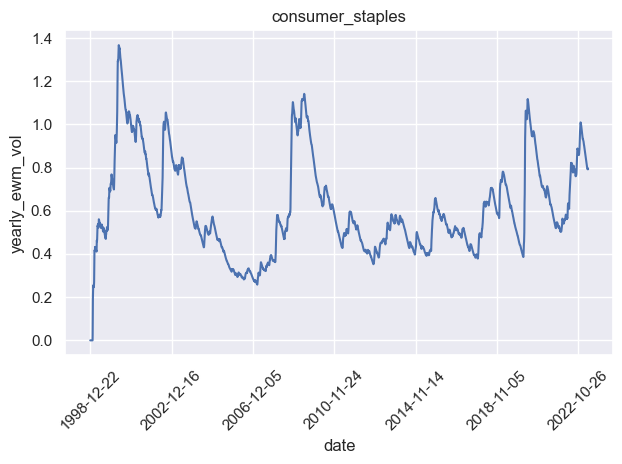

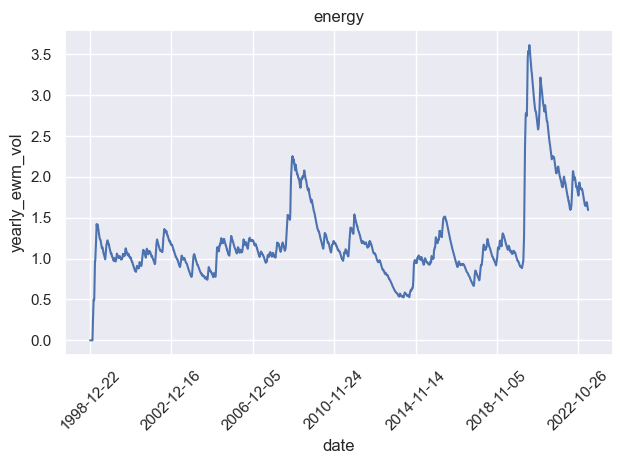

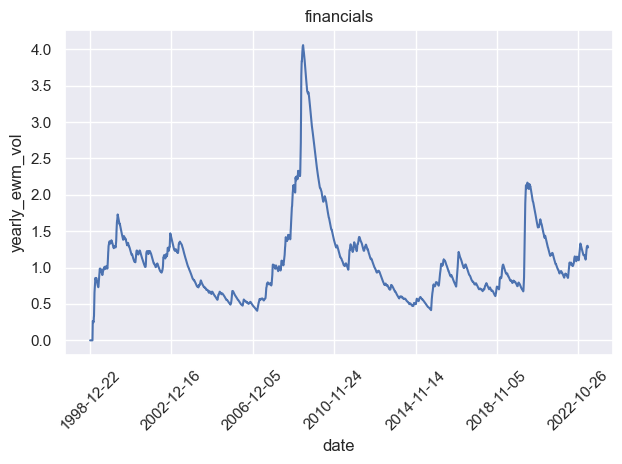

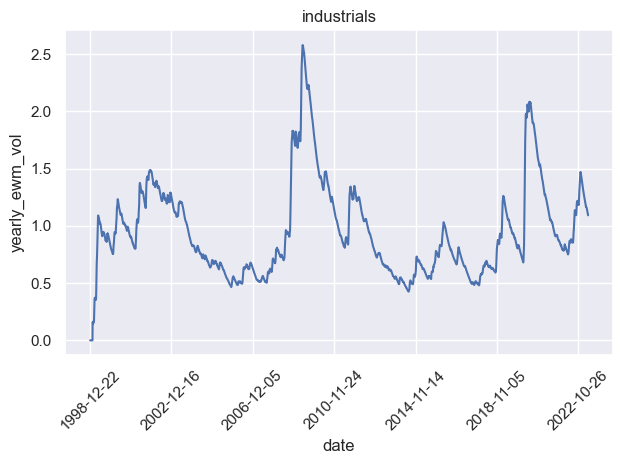

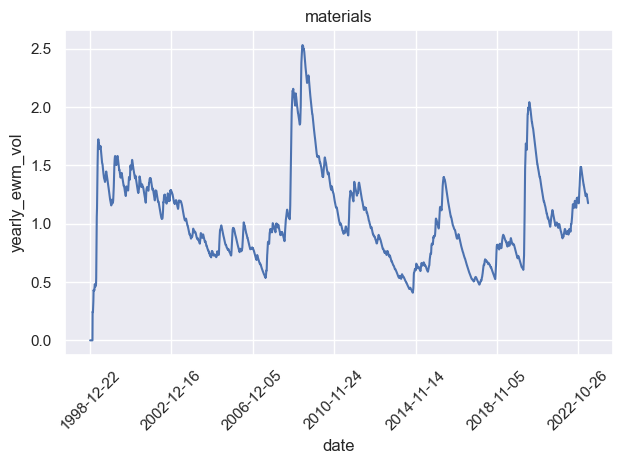

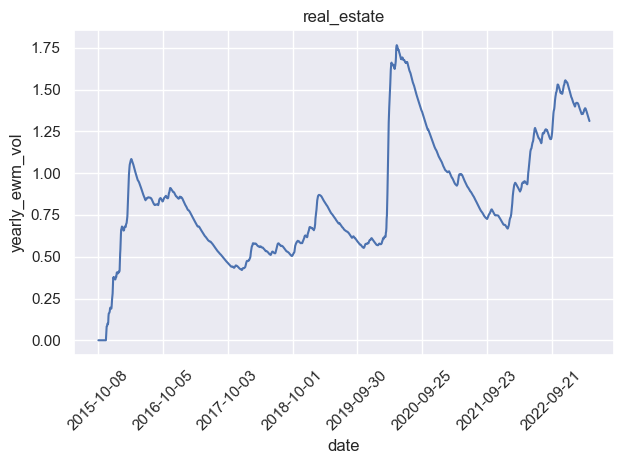

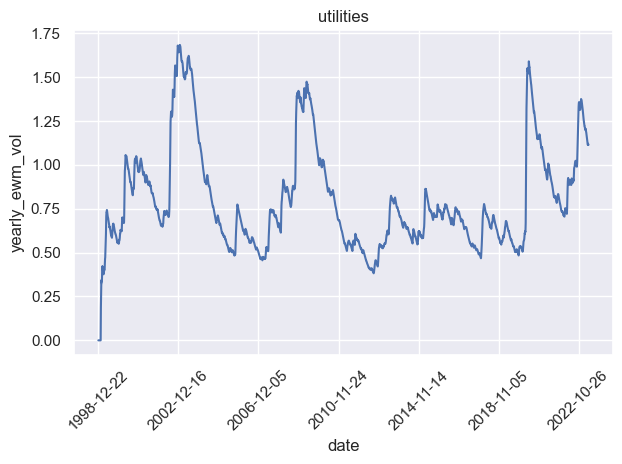

In [101]:
# ewm monthly volatility
index_data_df_rets = get_volatility(index_data_df_rets, interval=252, type='ewm', column_name='yearly_ewm_vol', rets_column='monthly_rets')

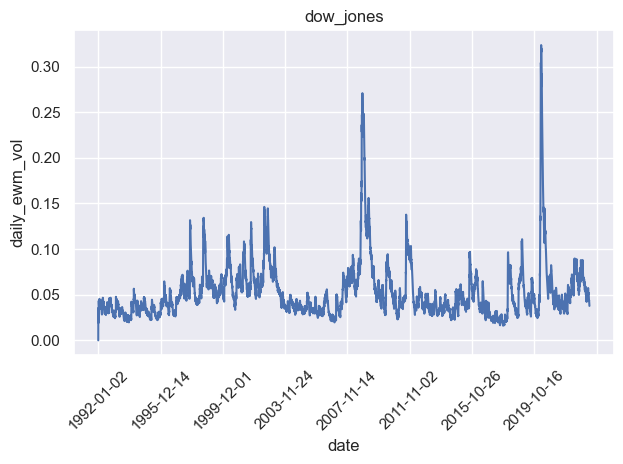

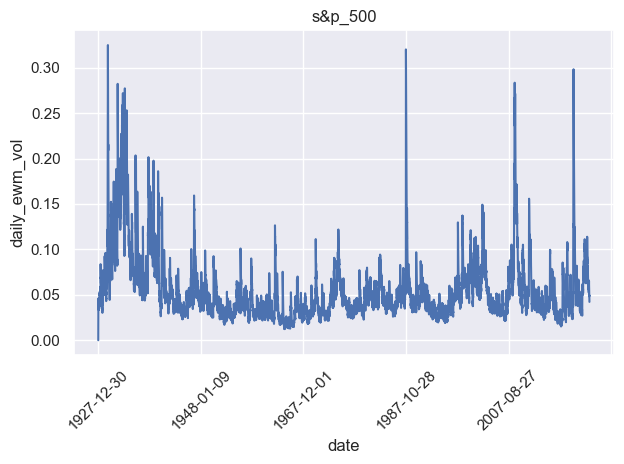

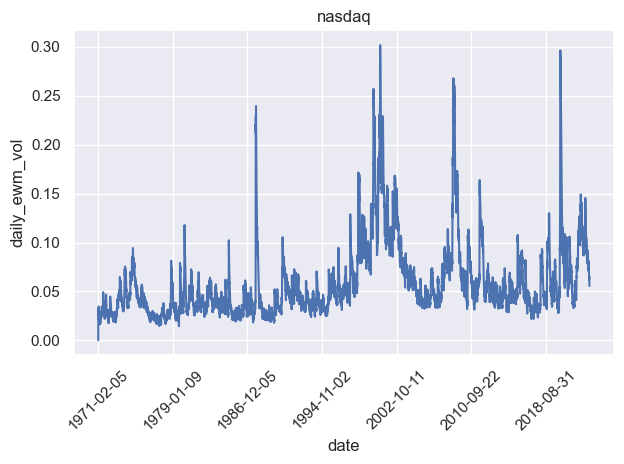

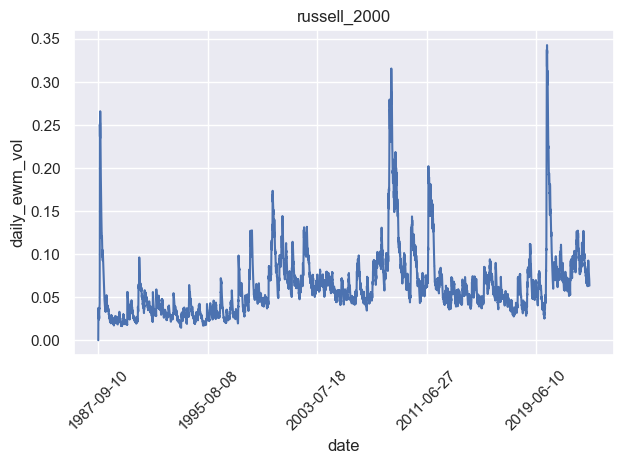

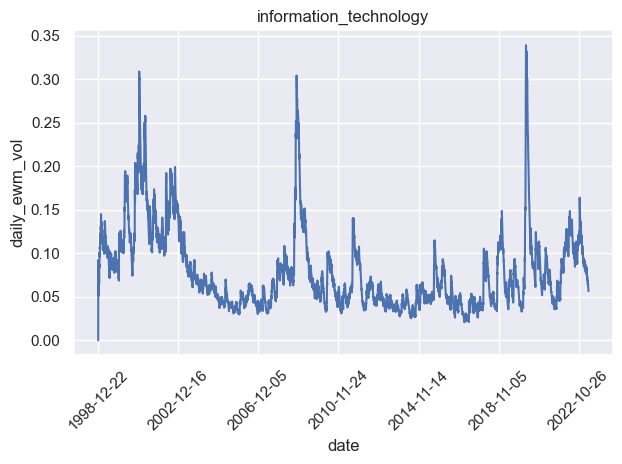

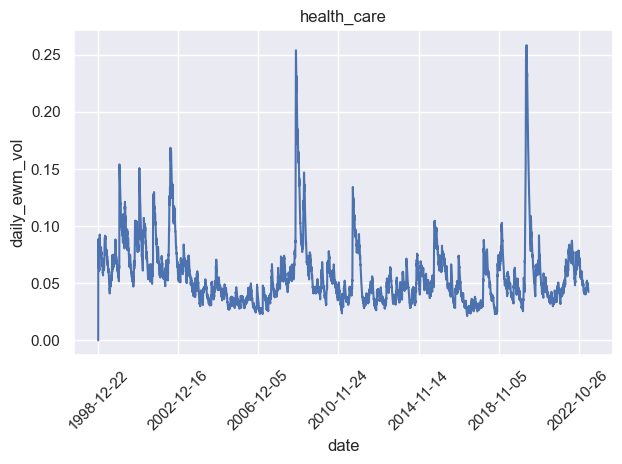

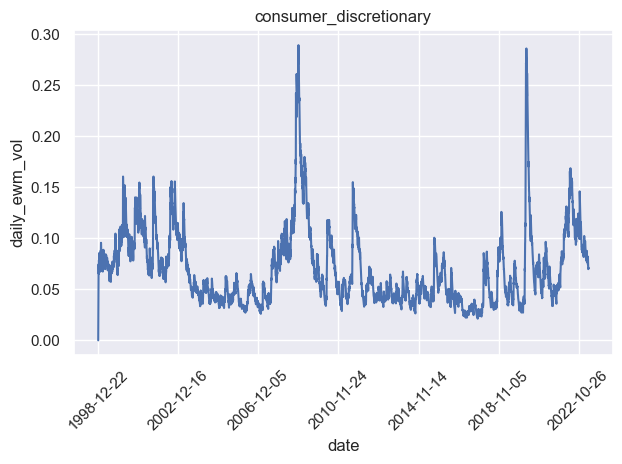

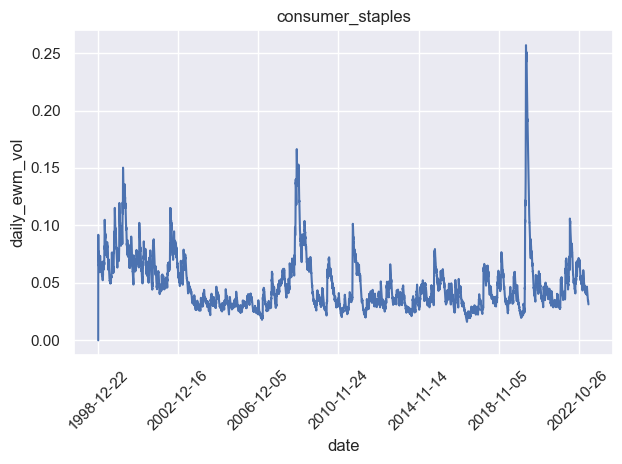

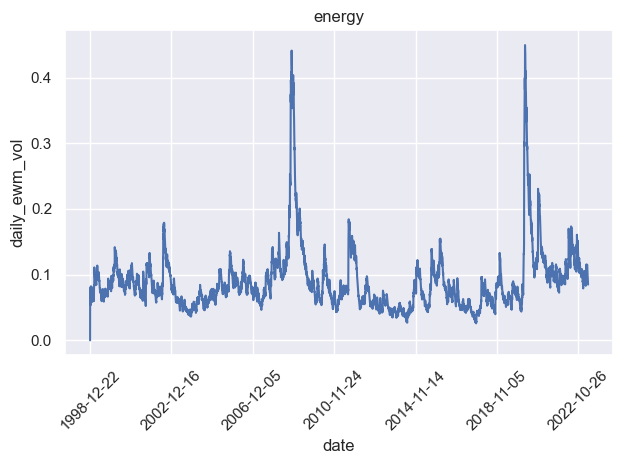

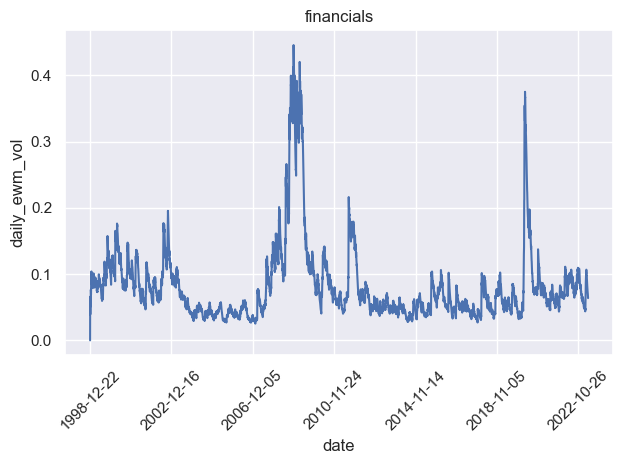

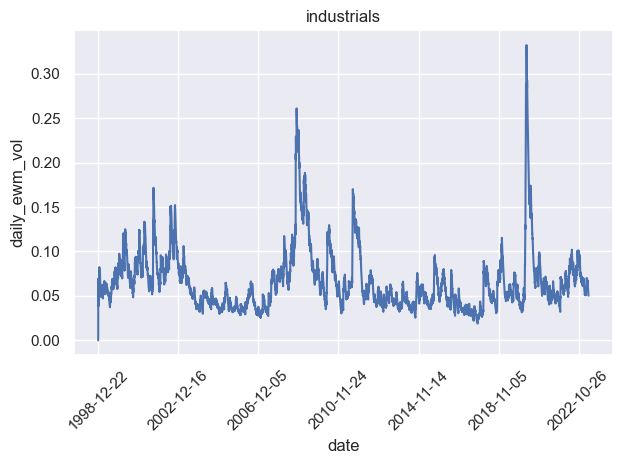

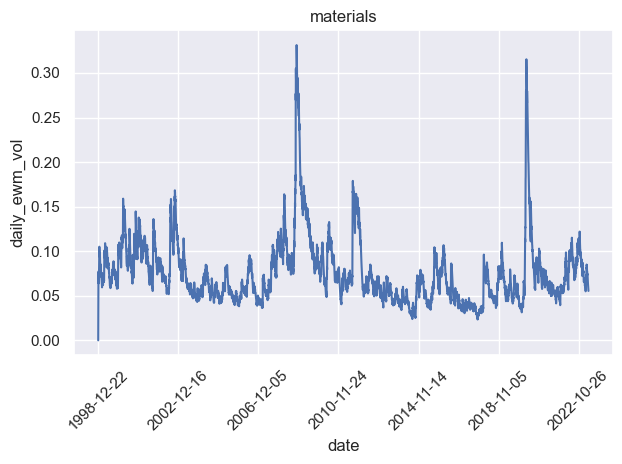

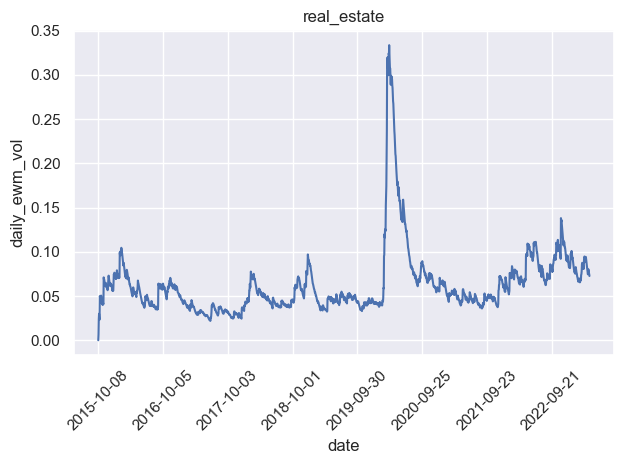

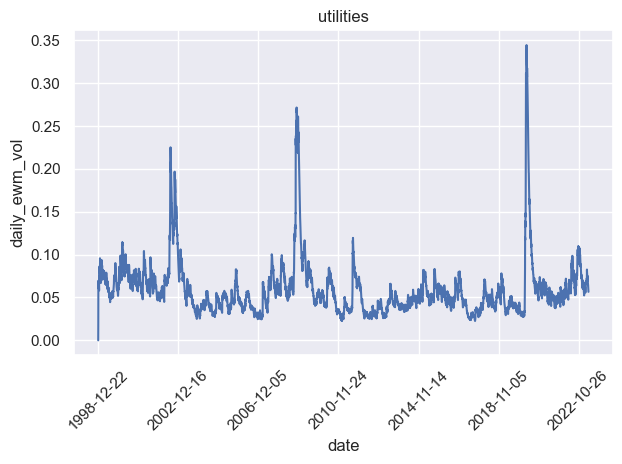

In [102]:
# daily ewm volatility
index_data_df_rets = get_volatility(index_data_df_rets, interval=30, type='ewm', column_name='daily_ewm_vol', rets_column='daily_rets')

# 3. Explanatory Data Analysis

In [103]:
# correlation between returns and volatility

indeces = index_data_df_rets['code'].unique().tolist()

for each_index in indeces:
    corr_daily = index_data_df_rets.loc[index_data_df_rets['code'] == each_index][['daily_rets', 'daily_ewm_vol']].corr()
    corr_monthly = index_data_df_rets.loc[index_data_df_rets['code'] == each_index][['monthly_rets', 'yearly_ewm_vol']].corr()
    print(each_index)
    print("Daily Correlation: {}")
    print(pd.DataFrame(corr_daily))

    print("Motnhly Correlation: {}")
    print(pd.DataFrame(corr_monthly))

^DJI
Daily Correlation: {}
               daily_rets  daily_ewm_vol
daily_rets       1.000000       0.009751
daily_ewm_vol    0.009751       1.000000
Motnhly Correlation: {}
                monthly_rets  yearly_ewm_vol
monthly_rets        1.000000        0.010434
yearly_ewm_vol      0.010434        1.000000
^GSPC
Daily Correlation: {}
               daily_rets  daily_ewm_vol
daily_rets        1.00000        0.00921
daily_ewm_vol     0.00921        1.00000
Motnhly Correlation: {}
                monthly_rets  yearly_ewm_vol
monthly_rets        1.000000        0.032809
yearly_ewm_vol      0.032809        1.000000
^IXIC
Daily Correlation: {}
               daily_rets  daily_ewm_vol
daily_rets       1.000000      -0.004524
daily_ewm_vol   -0.004524       1.000000
Motnhly Correlation: {}
                monthly_rets  yearly_ewm_vol
monthly_rets         1.00000        -0.01367
yearly_ewm_vol      -0.01367         1.00000
^RUT
Daily Correlation: {}
               daily_rets  daily_ewm_vol
dai

In [138]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# get train data
X_train = pd.DataFrame()

codes = index_data_df_rets['code'].unique().tolist()

for code in codes:
    code_df = index_data_df_rets.loc[index_data_df_rets['code'] == code][['yearly_rolling_vol']]
    code_df.columns = [code]
    print(code_df.head())
    X_train = pd.concat([X_train, code_df], axis=1).sort_index()
    print(X_train.tail())

X_train.fillna(0, inplace=True)
X_train = X_train.loc['1992-01-02':]

            ^DJI
date            
1992-01-02   0.0
1992-01-03   0.0
1992-01-06   0.0
1992-01-07   0.0
1992-01-08   0.0
                ^DJI
date                
2023-04-17  1.044045
2023-04-18  1.043983
2023-04-19  1.044216
2023-04-20  1.042602
2023-04-21  1.040743
            ^GSPC
date             
1927-12-30    0.0
1928-01-03    0.0
1928-01-04    0.0
1928-01-05    0.0
1928-01-06    0.0
                ^DJI     ^GSPC
date                          
2023-04-17  1.044045  1.096274
2023-04-18  1.043983  1.096731
2023-04-19  1.044216  1.097674
2023-04-20  1.042602  1.096226
2023-04-21  1.040743  1.095295
            ^IXIC
date             
1971-02-05    0.0
1971-02-08    0.0
1971-02-09    0.0
1971-02-10    0.0
1971-02-11    0.0
                ^DJI     ^GSPC     ^IXIC
date                                    
2023-04-17  1.044045  1.096274  1.419536
2023-04-18  1.043983  1.096731  1.420578
2023-04-19  1.044216  1.097674  1.422113
2023-04-20  1.042602  1.096226  1.421213
2023-04-21  1.04074

In [139]:
# 요인추출 가능성 확인
# Barlett's test
# 단위 행렬보다 변수들이 상관성이 있는지(p-value 작고) 여부 파악

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

statistics_bar, p_value = calculate_bartlett_sphericity(X_train)
statistics_bar, p_value

(229287.5590374155, 0.0)

In [140]:
# 요인추출 가능성 확인
# Kalser-Meyer-Olkln (KMO) Test
# 모든 변수들 사이에서 분산의 비율 파악
# KMO 통계량이 크고(p-value작고) 공통된 변수를 추출하는 요인분석 적합

from factor_analyzer.factor_analyzer import calculate_kmo

kmo_each, kmo_all = calculate_kmo(X_train)
kmo_each, kmo_all

/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


(array([0.87459772, 0.86028466, 0.61278355, 0.76465963, 0.80457361,
        0.9452047 , 0.91851779, 0.8812425 , 0.83238579, 0.91343013,
        0.83243428, 0.92121249, 0.62902018, 0.78567521]),
 0.8415139630289257)

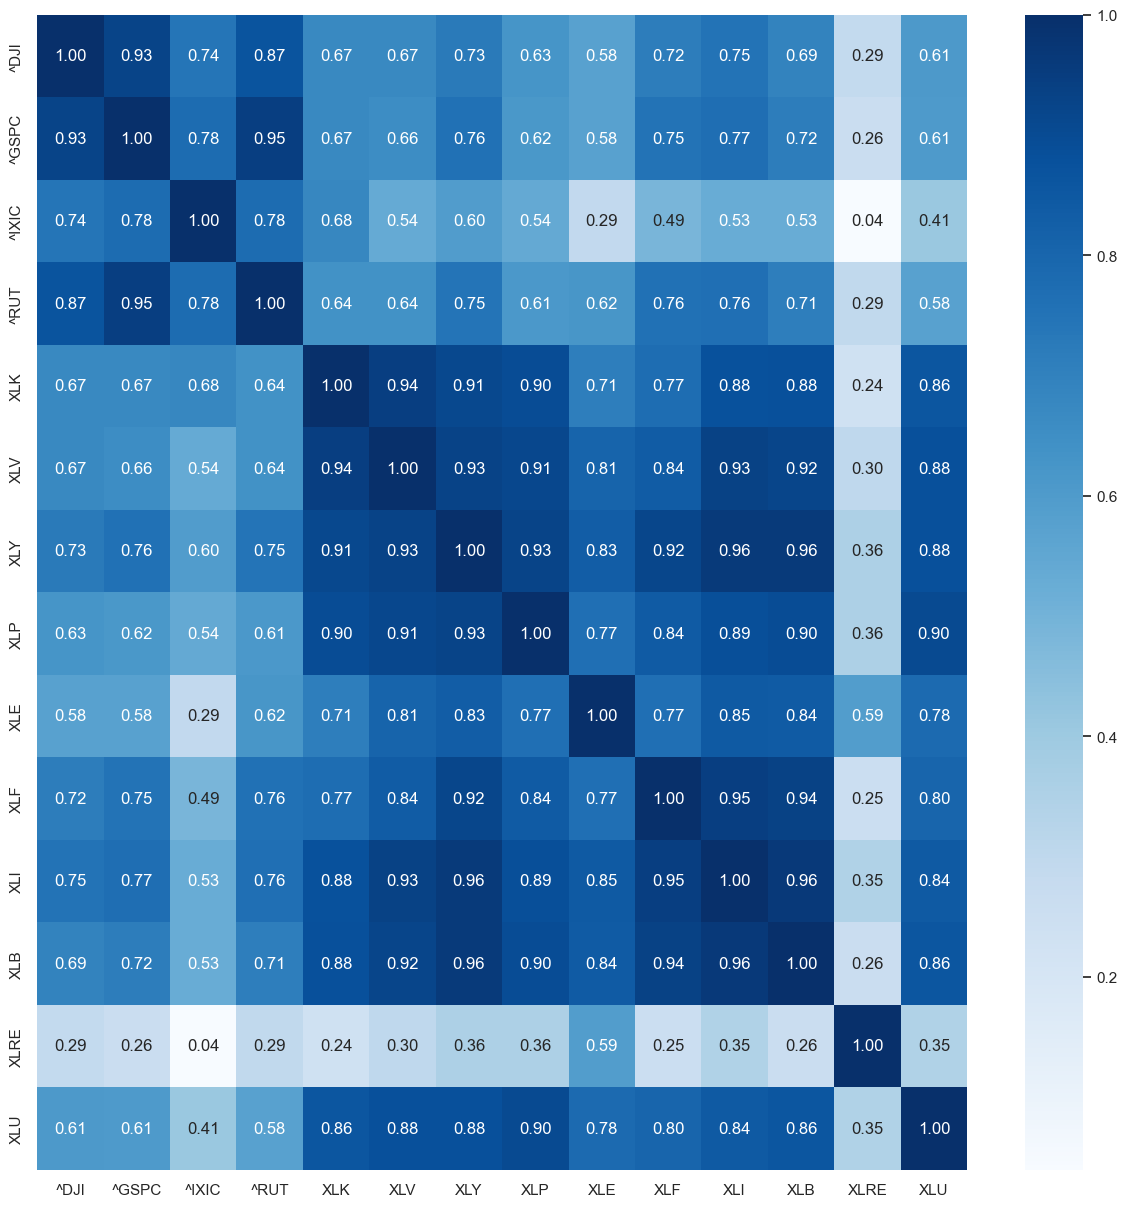

In [141]:
# 상관관계
# 강하게 묶이는 변수 관계성 확인
plt.figure(figsize=(15, 15))
sns.heatmap(pd.DataFrame(X_train, columns=X_train.columns).corr(), 
            cmap='Blues', annot=True, fmt='.2f')
plt.show()

## Factor Analysis

In [142]:
# 모델링1
# 최적 요인 수 추론

from factor_analyzer import FactorAnalyzer

model_fa = FactorAnalyzer()
model_fa.fit(X_train)
eigenvalues, factor_eigenvalues = model_fa.get_eigenvalues()

# original_eigenvalues : 고유 팩터, Factor_eigenvalues : 회전 팩터
fa_result = pd.DataFrame([eigenvalues, factor_eigenvalues],
                         index=['Original_Eigenvalues', 'Factor_Eigenvalues']).T
fa_result

Original_Eigenvalues  Factor_Eigenvalues
0              10.333730           10.165301
1               1.465932            1.311389
2               0.993333            0.644038
3               0.467707            0.234026
4               0.204998            0.125318
5               0.165947            0.074150
6               0.134213            0.049822
7               0.079334           -0.004976
8               0.054738           -0.053471
9               0.035628           -0.111695
10              0.023345           -0.200516
11              0.019213           -0.235126
12              0.015040           -0.291669
13              0.006843           -0.374930

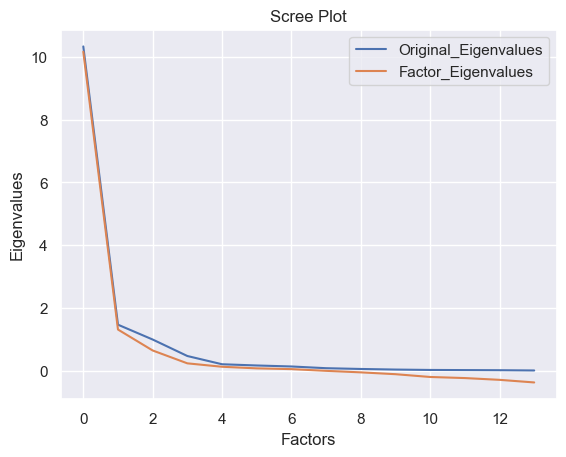

In [143]:
# Create scree plot using matplolib
fa_result.plot()
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.grid(True)
plt.show()

In [144]:
# 모델링2
# 최적 요인 수 비교를 위한 귀무가설/대중주장/H0 확인
# 요인 적재량 확인
# (a) varimax (orthogonal rotation)
# (b) promax (oblique rotation)
# (c) oblimin (oblique rotation)
# (d) oblimax (orthogonal rotation)
# (e) quartimin (oblique rotation)
# (f) quartimax (orthogonal rotation)
# (g) equamax (orthogonal rotation)

num_factors = X_train.shape[1]
model_fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
model_fa.fit(X_train)
colnames = ['Factor' + str(i) for i in range(num_factors)]
fa_loadings = pd.DataFrame(model_fa.loadings_,
                           index=X_train.columns,
                           columns=colnames)
fa_loadings

Factor0   Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
^DJI   0.400171  0.833593  0.167724  0.064371 -0.016101  0.030646 -0.029152   
^GSPC  0.391375  0.900200  0.130481  0.042692 -0.006315  0.031658 -0.029159   
^IXIC  0.259822  0.736034 -0.087856  0.614243 -0.008534  0.000197 -0.000949   
^RUT   0.371751  0.868905  0.177614  0.091364  0.117851  0.001083  0.081724   
XLK    0.839256  0.344148  0.079540  0.353290 -0.001101  0.052552 -0.109592   
XLV    0.896844  0.317684  0.148756  0.136399  0.033437 -0.023919 -0.134806   
XLY    0.851391  0.429994  0.208318  0.125640  0.018213 -0.015808  0.069520   
XLP    0.879012  0.265448  0.220431  0.216405 -0.095921  0.069534  0.041804   
XLE    0.714200  0.254340  0.544061 -0.048891  0.347399 -0.012292  0.007737   
XLF    0.806050  0.485720  0.088486 -0.116158  0.028333 -0.066834  0.261823   
XLI    0.845695  0.467475  0.195293 -0.022828  0.032667 -0.119268  0.033499   
XLB    0.886456  0.395444  0.097033  0.025576  0.158072 -0.066367  0.046698   
XLRE   0.162604  0.100996  0.837550 -0.005970 -0.012091  0.014988  0.002638   
XLU    0.862986  0.252730  0.209410  0.026190 -0.014064  0.363137 -0.025203   

        Factor7   Factor8   Factor9  Factor10  Factor11  Factor12  Factor13  
^DJI  -0.214292 -0.007932  0.031820 -0.025076  0.030239  0.000537       0.0  
^GSPC  0.005142  0.037430 -0.043306  0.039657 -0.076487 -0.000446       0.0  
^IXIC  0.004564 -0.021707  0.003289  0.011652  0.004613 -0.002274       0.0  
^RUT   0.190682 -0.025449  0.024272 -0.026723  0.055056  0.001728       0.0  
XLK   -0.039655  0.139019  0.009273 -0.065307 -0.029744  0.012962       0.0  
XLV   -0.035558  0.037533  0.161022 -0.021002  0.009726 -0.003973       0.0  
XLY    0.026239  0.033857 -0.047167  0.128033 -0.013871 -0.001106       0.0  
XLP   -0.002579 -0.198792 -0.020317 -0.026783 -0.003371  0.002356       0.0  
XLE    0.021395  0.020827  0.006708  0.000535 -0.000482  0.002007       0.0  
XLF    0.040983 -0.025132 -0.021718  0.006655  0.002795  0.000005       0.0  
XLI    0.020661  0.056042  0.002854 -0.028222  0.018741  0.038396       0.0  
XLB   -0.002961 -0.020031 -0.094825  0.018915  0.016016 -0.034112       0.0  
XLRE  -0.003329 -0.003920  0.000234  0.000431  0.000347  0.000149       0.0  
XLU   -0.007606 -0.008113 -0.000872 -0.002555 -0.001009  0.000725       0.0

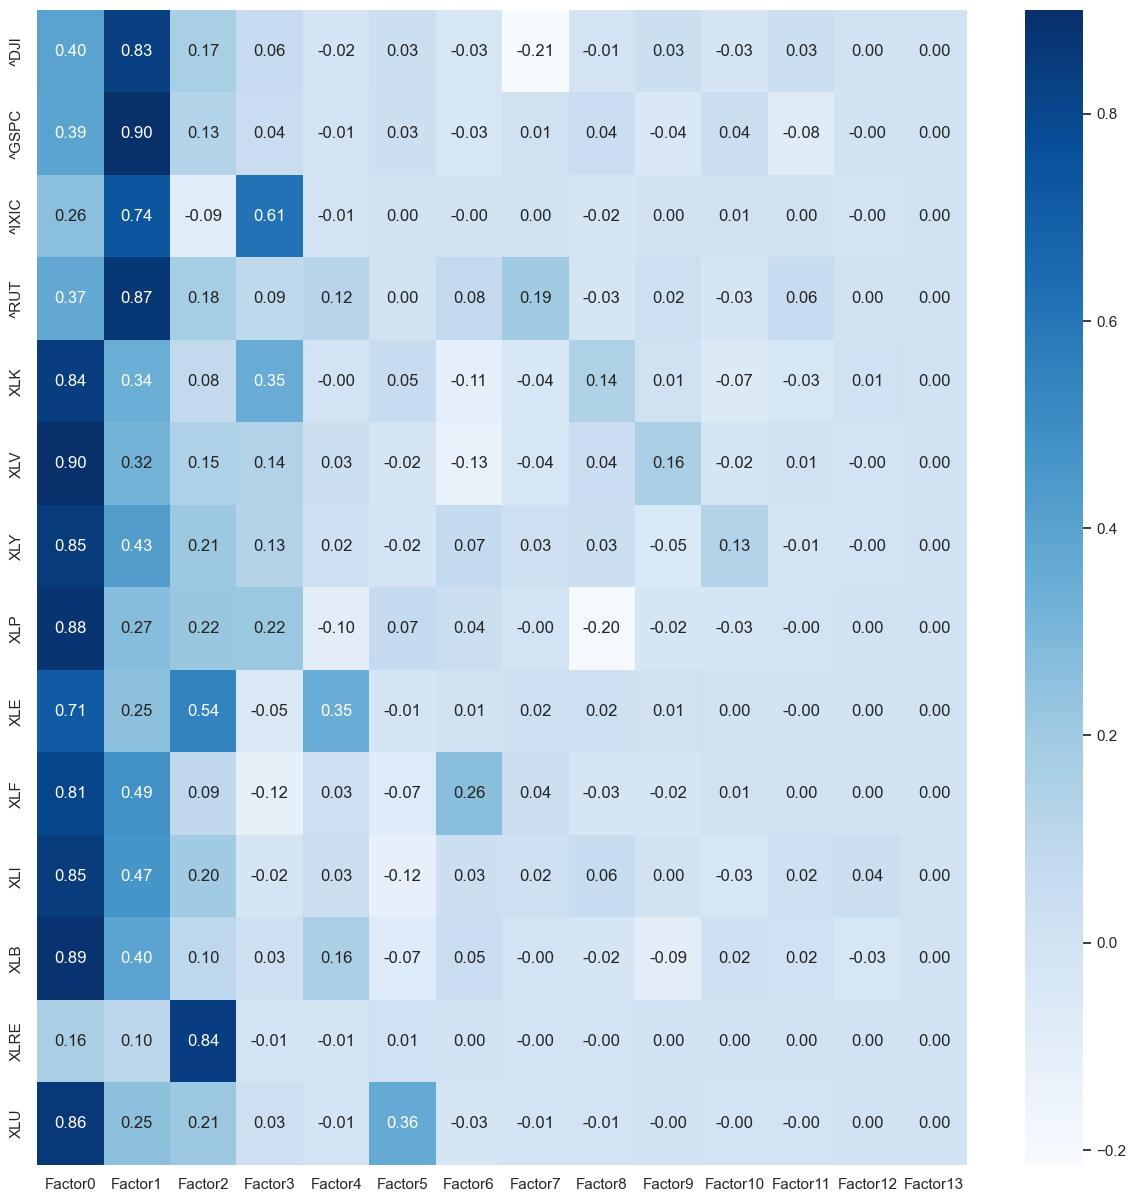

Factor0   Factor1   Factor2   Factor3   Factor4  \
Variance               6.957212  4.026292  1.301592  0.615423  0.172799   
Proportional Variance  0.496944  0.287592  0.092971  0.043959  0.012343   
Cumulative Variances   0.496944  0.784536  0.877507  0.921466  0.933808   

                        Factor5   Factor6   Factor7   Factor8   Factor9  \
Variance               0.165702  0.117700  0.088502  0.068671  0.041657   
Proportional Variance  0.011836  0.008407  0.006322  0.004905  0.002975   
Cumulative Variances   0.945644  0.954051  0.960373  0.965278  0.968253   

                       Factor10  Factor11  Factor12  Factor13  
Variance               0.026073  0.011617  0.002842  0.000000  
Proportional Variance  0.001862  0.000830  0.000203  0.000000  
Cumulative Variances   0.970116  0.970946  0.971149  0.971149

In [145]:
# 귀무가설/대중주장/H0에서의 요인과 변수관계 시각화
## Heatmap 시각화

plt.figure(figsize=(15, 15))
sns.heatmap(fa_loadings, cmap='Blues', annot=True, fmt='.2f')
plt.show()

## 테이블강조 시각화
criteria = pd.Series([0.5] * num_factors, index=colnames)
fa_loadings_light = fa_loadings.style.highlight_between(left=criteria, right=1, axis=1,
                                                        props='color:white; background-color:purple;')
display(fa_loadings_light)

## 분산설명력 테이블강조
fa_variance = pd.DataFrame(model_fa.get_factor_variance(), columns=colnames,
                           index=['Variance', 'Proportional Variance', 'Cumulative Variances'])
fa_variance

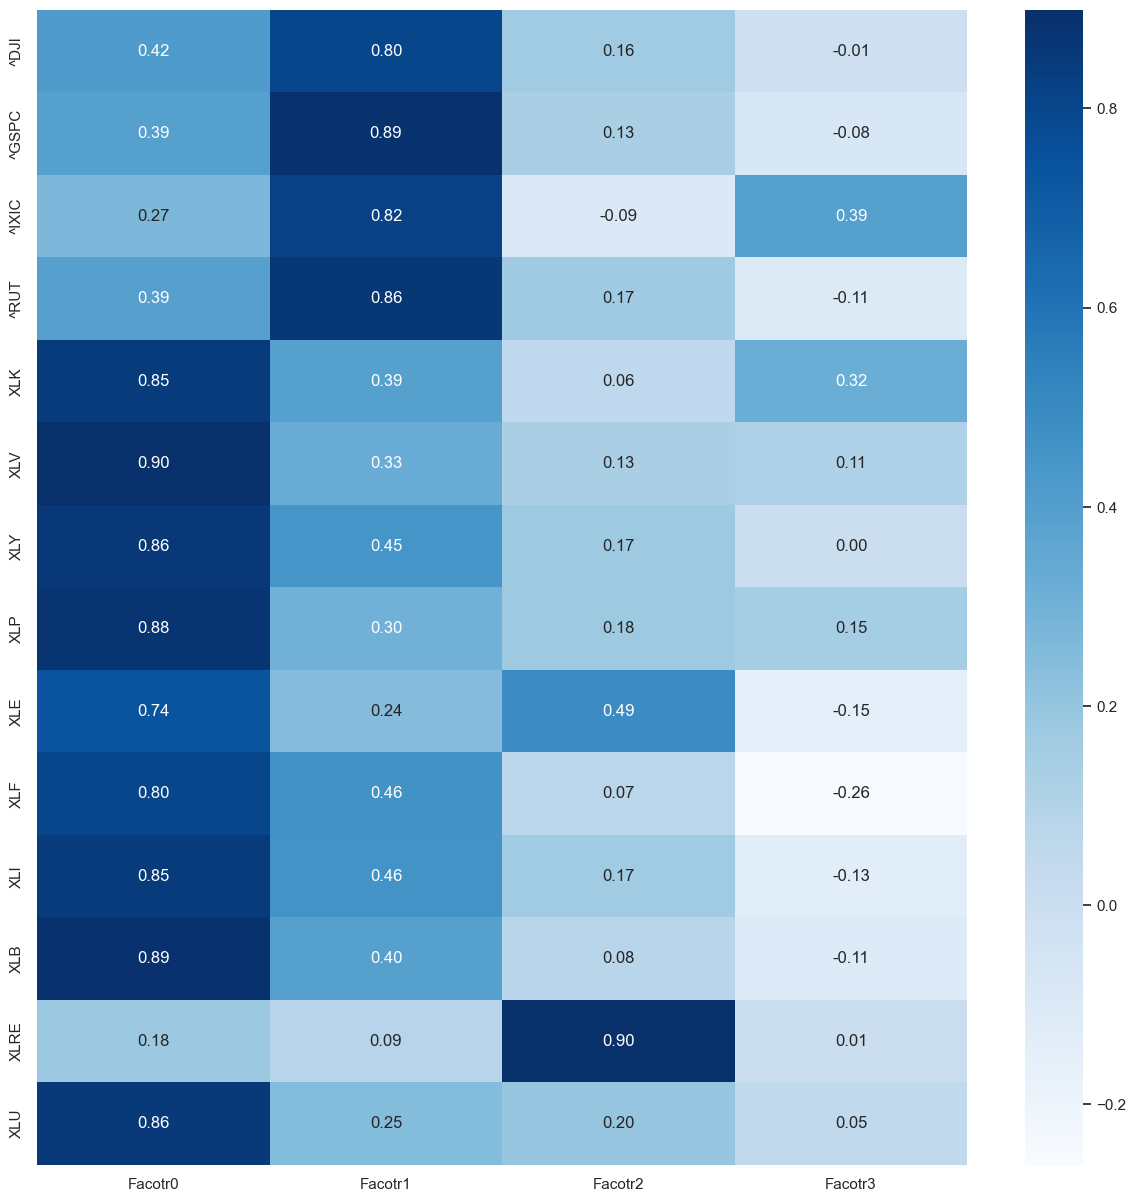

Facotr0   Facotr1   Facotr2   Facotr3
Variance               7.056685  4.121281  1.289726  0.433592
Proportional Variance  0.504049  0.294377  0.092123  0.030971
Cumulative Variances   0.504049  0.798426  0.890549  0.921520

In [146]:
# 모델링
# 최적 요인 수 비교를 위한 대립가설/나의주장/H1 확인
# 대립가설/나의주장/H1에서의 요인과 변수관계 시각화
# (a) varimax (orthogonal rotation)
# (b) promax (oblique rotation)
# (c) oblimin (oblique rotation)
# (d) oblimax (orthogonal rotation)
# (e) quartimin (oblique rotation)
# (f) quartimax (orthogonal rotation)
# (g) equamax (orthogonal rotation)

num_factors = 4
model_fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
model_fa.fit(X_train)
colnames = ['Facotr' + str(i) for i in range(num_factors)]
fa_loadings = pd.DataFrame(model_fa.loadings_,
                           index=X_train.columns,
                           columns=colnames)

## Heatmap 시각화
plt.figure(figsize=(15, 15))
sns.heatmap(fa_loadings, cmap='Blues', annot=True, fmt='.2f')
plt.show()

## 테이블강조 시각화
criteria = pd.Series([0.5] * num_factors, index=colnames)
fa_loadings_light = fa_loadings.style.highlight_between(left=criteria, right=1, axis=1,
                                                        props='color:white; background-color:purple;')
criteria = pd.Series([-1] * num_factors, index=colnames)
fa_loadings_light = fa_loadings_light.highlight_between(left=criteria, right=-0.5, axis=1,
                                                        props='color:white; background-color:purple;')
display(fa_loadings_light)

## 분산설명력 테이블강조
fa_variance = pd.DataFrame(model_fa.get_factor_variance(), columns=colnames,
                           index=['Variance', 'Proportional Variance', 'Cumulative Variances'])
fa_variance

In [147]:
# 공통성 추정
# 변수의분산이 추출된 요인들에 의해 설명되는 정도로 0.5 이상 좋음
fa_communality = pd.DataFrame(model_fa.get_communalities(),
                              index=X_train.columns, columns=['Communality'])
criteria = pd.Series([0.5] * len(fa_communality.columns), index=fa_communality.columns)
fa_communality_light = fa_communality.style.highlight_between(left=criteria, right=1, axis=1,
                                                              props='color:white; background-color:purple;')
fa_communality_light

## Non-negative Matrix Factorization

In [149]:
# import NMF
from sklearn.decomposition import NMF

n_factor = 5
model_nmf = NMF(n_components=n_factor, init='random', random_state=123)
model_nmf.fit(X_train)
X_train_nmf = model_nmf.transform(X_train)

/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


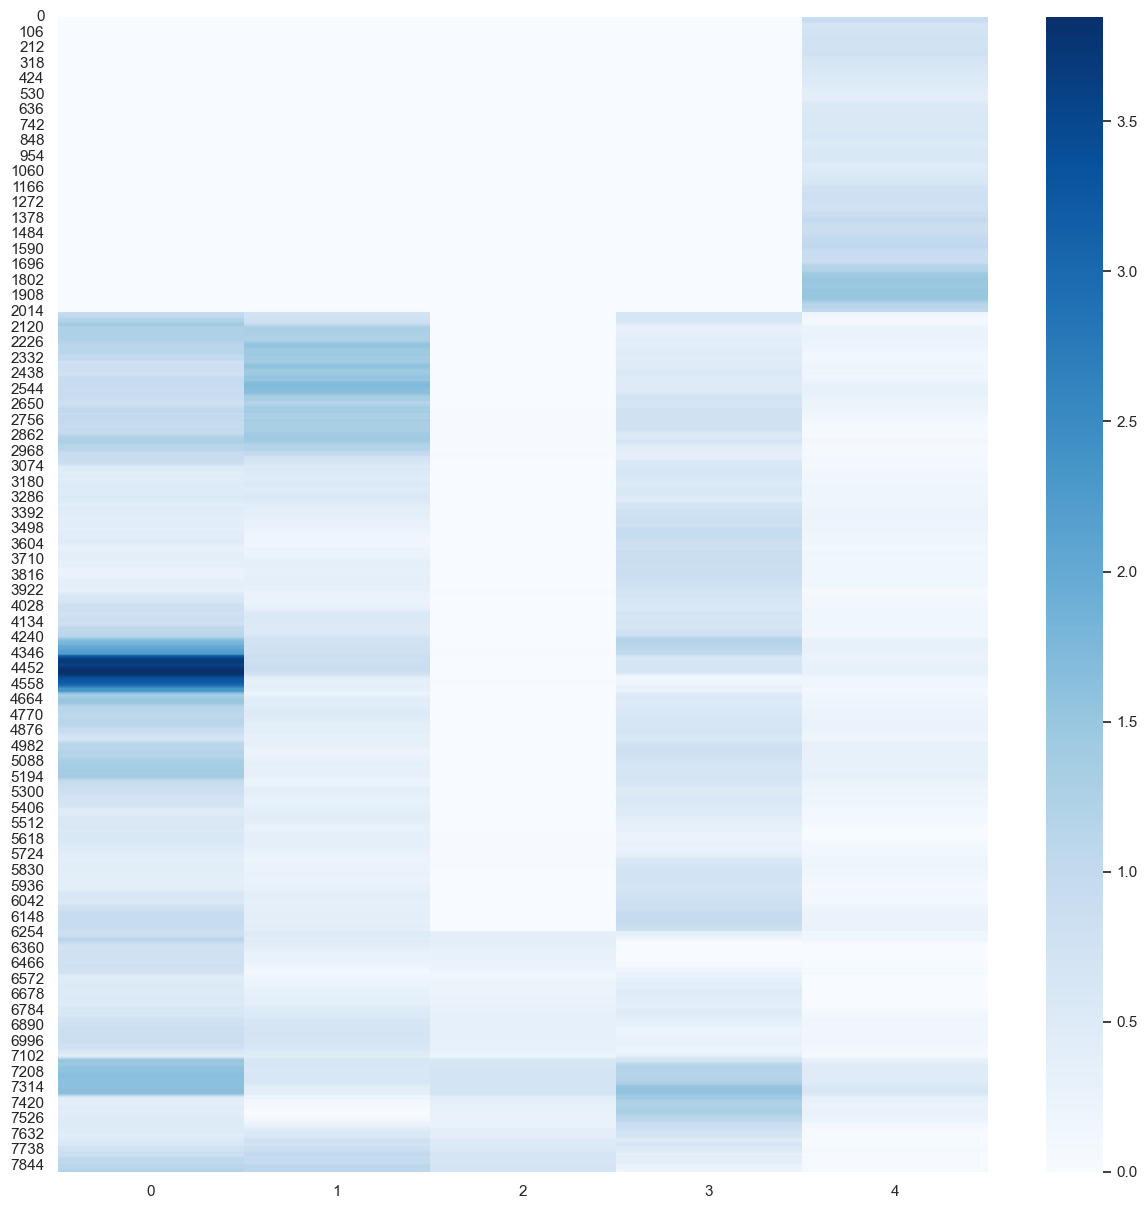

In [151]:
# Test 가중치 행렬 W 시각화
plt.figure(figsize=(15, 15))
sns.heatmap(X_train_nmf, annot=False, fmt='.2f', cmap='Blues')
plt.show()

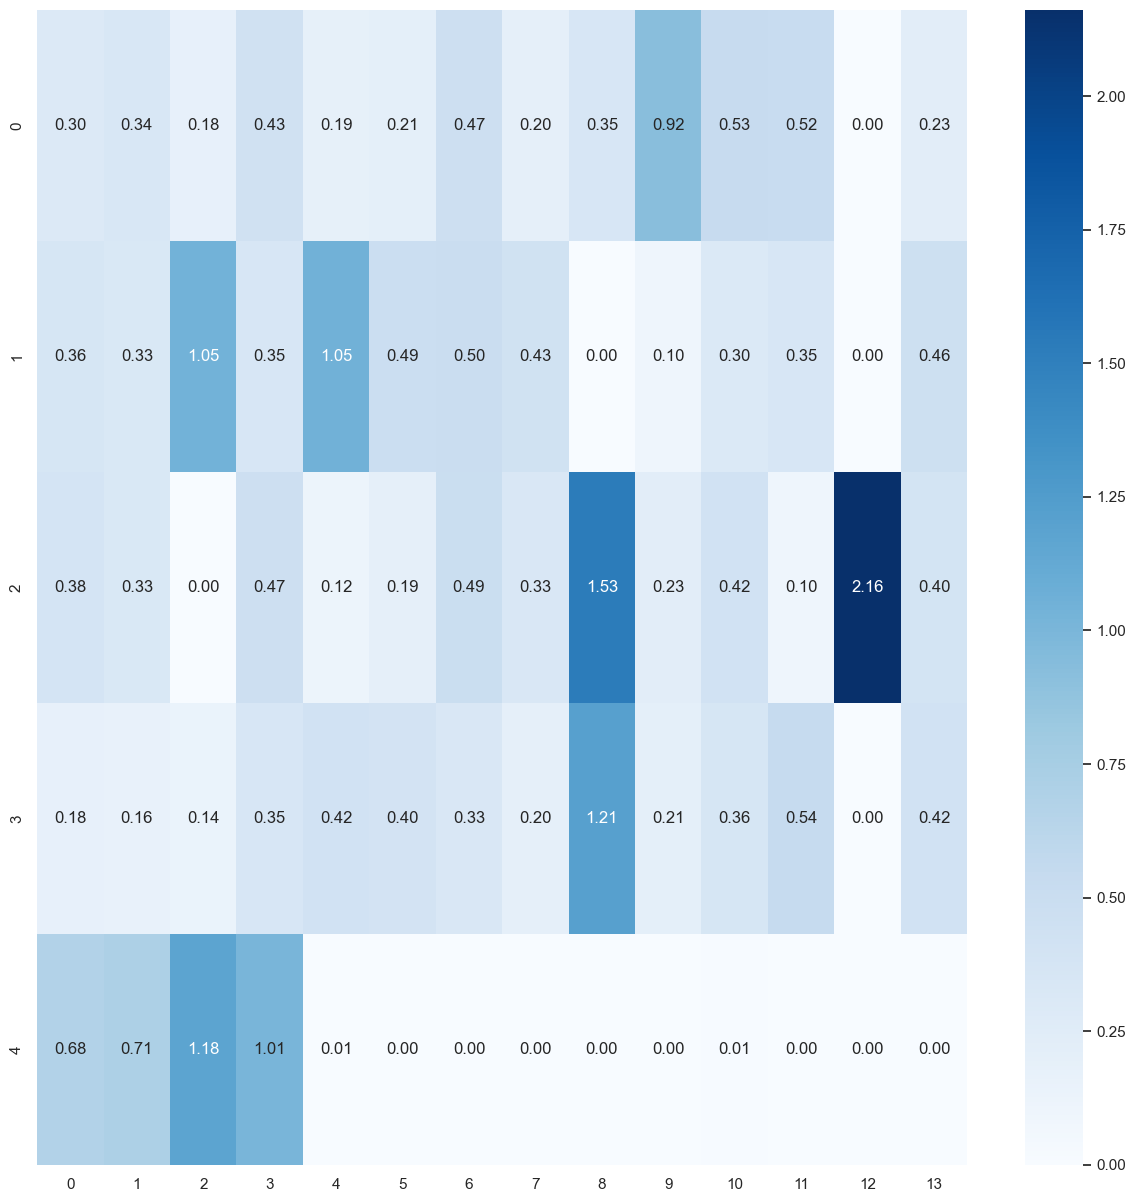

In [152]:
# 특성 행렬 H 시각화
plt.figure(figsize=(15, 15))
sns.heatmap(model_nmf.components_, annot=True, fmt='.2f', cmap='Blues')
plt.show()